In [1]:
%pylab 
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation
from landlab.components.conduit_networks.calcite import calcite_diss_palmer_transfer

from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, 
               vmin=0., vmax=0., cmap_name='viridis', 
               magnitude= False, lw=5, 
               pixels_per_node=31, x_name='X', 
               y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixels_per_node)), int(round(grid.number_of_cell_rows*pixels_per_node)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
mg = RasterModelGrid((25,25),500)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')

#set heads at edges
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'][mg.active_links]= 0.1*np.random.rand(mg.number_of_active_links)+0.1

rates = mg.add_zeros('link','diss__rates')

#code added for fsolve algorithm
#dhdx = mg.add_zeros('link', 'hydraulic_head_gradient')
#net_node_flux = mg.add_ones('node', 'net_node_flux')


pfn = PresFlowNetwork(mg, solutes=['Ca', 'PCO2'], 
                      transfer_func=calcite_diss_palmer_transfer,
                     transfer_func_link_variables = ['hydraulic__diameter','conduit__discharge'],
                     transfer_kwd_args = {'T_C':10.})
#Here need to set boundary conditions for transport calculation
#add input to node 310
Ca = mg.at_node['concentration__Ca']
PCO2 = mg.at_node['concentration__PCO2']

input_Q=.05
input_C = 0.001
input_idx = 30+250#11
mg.at_node['input__discharge'][input_idx] = input_Q
mg.at_node['Ca__inflow_conc'][input_idx] = input_C 
mg.at_node['PCO2__inflow_conc'][input_idx] = 0.05

Ca[mg.nodes_at_left_edge] = 0.0005
Ca[mg.nodes_at_right_edge] = 0.
Ca[mg.nodes_at_top_edge] = 0.
Ca[mg.nodes_at_bottom_edge] = 0.

PCO2[mg.nodes_at_left_edge] = 0.01
PCO2[mg.nodes_at_right_edge] = 0.
PCO2[mg.nodes_at_top_edge] = 0.
PCO2[mg.nodes_at_bottom_edge] = 0.




#mg.at_link['Ca__conc_in']

Number of links =  1200
Number of nodes =  625
Number of active links =  1058
Number of core nodes =  529


In [5]:
nsteps = 10000
step_start=0
dt = 1. #yr
every = 10
fig1, axs = subplots(2,3,figsize=(9,10))
for step in arange(nsteps)+step_start:
    print("Step: ",step)
    pfn.run_one_step(transport=True)
    #Calculate change of conduit diameters
    ddh_dt = mg.at_link['diss__rates']*0.001*dt
    mg.at_link['hydraulic__diameter'] += ddh_dt#[mg.active_links]
    print("max ddh_dt = ",str(max(ddh_dt)))
    print("min ddh_dt = ",str(min(ddh_dt)))
    print("max d_h=",str(max(d_h)))
    #Reset boundary node values
    Ca[mg.nodes_at_left_edge] = 0.0005
    Ca[mg.nodes_at_right_edge] = 0.
    Ca[mg.nodes_at_top_edge] = 0.
    Ca[mg.nodes_at_bottom_edge] = 0.

    PCO2[mg.nodes_at_left_edge] = 0.01
    PCO2[mg.nodes_at_right_edge] = 0.
    PCO2[mg.nodes_at_top_edge] = 0.
    PCO2[mg.nodes_at_bottom_edge] = 0.

    if (step % every)==0: #make an animation frame
        subplot(3,2,1)
        imshow_grid_at_node(mg, h, var_name='Head ($m$)', cmap='viridis')
        subplot(3,2,2)
        plot_links(mg, 'conduit__discharge', magnitude=True, var_name='Discharge ($m^3/s$)', lw=9,use_PIL=True)
        subplot(3,2,3)
        plot_links(mg, 'hydraulic__diameter', var_name='Hydraulic diameter ($m$)', lw=9,use_PIL=True)
        subplot(3,2,4)#, position=[0.2,0.2,0.9,0.9])
        plot_links(mg, 'diss__rates', var_name='Dissolution rate ($mm/yr$)', lw=9,use_PIL=True)
        subplot(3,2,5)
        imshow_grid_at_node(mg, Ca, var_name='Calcium ($mol/L$)', cmap='viridis')        
        subplot(3,2,6)
        imshow_grid_at_node(mg, PCO2, var_name='PCO2 (atm)', cmap='viridis')        
        image_name = 'speleo_example/speleogenesis_output'+str(step).zfill(6)+'.png'
        subplots_adjust(wspace=0.3)
        savefig(image_name)
        fig1.clf()


Step:  0
Number of iterations = 1 tolerance = 0.125759081284  iteration time= 0.16797208786010742
Number of iterations = 2 tolerance = 0.0390624401327  iteration time= 0.16439080238342285
Number of iterations = 3 tolerance = 0.0195383288769  iteration time= 0.1560208797454834
Number of iterations = 4 tolerance = 0.00983828874694  iteration time= 0.16233396530151367
Number of iterations = 5 tolerance = 0.00512151396912  iteration time= 0.15436339378356934
Number of iterations = 6 tolerance = 0.00411908552274  iteration time= 0.16632509231567383
Number of iterations = 7 tolerance = 0.00315706005933  iteration time= 0.1559450626373291
Number of iterations = 8 tolerance = 0.00128898765458  iteration time= 0.16383743286132812
Number of iterations = 9 tolerance = 0.000486127519897  iteration time= 0.154571533203125
Number of iterations = 10 tolerance = 0.00031674387152  iteration time= 0.16621661186218262
Number of iterations = 11 tolerance = 8.46950158698e-05  iteration time= 0.173543930053

Number of iterations = 2 tolerance = 1.8242726352e-06  iteration time= 0.1625053882598877
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.231512697818
Step:  28
Number of iterations = 1 tolerance = 9.62091216822e-05  iteration time= 0.17342686653137207
Number of iterations = 2 tolerance = 2.60591139124e-06  iteration time= 0.16656041145324707
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.232690157706
Step:  29
Number of iterations = 1 tolerance = 0.000101531649743  iteration time= 0.15907621383666992
Number of iterations = 2 tolerance = 2.99524018974e-06  iteration time= 0.16221117973327637
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.233867617594
Step:  30
Number of iterations = 1 tolerance = 9.13591206515e-05  iteration time= 0.1819441318511963
Number of iterations = 2 tolerance = 2.40471699033e-06  iteration time= 0.1675584316253662
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.235045077482
Step:  31
Number of iterations = 1 tol

max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.265659034569
Step:  57
Number of iterations = 1 tolerance = 9.10295419431e-05  iteration time= 0.16019201278686523
Number of iterations = 2 tolerance = 4.03249110206e-06  iteration time= 0.16098618507385254
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.266836494457
Step:  58
Number of iterations = 1 tolerance = 9.47552616589e-05  iteration time= 0.1528456211090088
Number of iterations = 2 tolerance = 1.31552969782e-06  iteration time= 0.1590273380279541
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.268013954345
Step:  59
Number of iterations = 1 tolerance = 9.84891379788e-05  iteration time= 0.16819453239440918
Number of iterations = 2 tolerance = 1.4596154368e-06  iteration time= 0.16147303581237793
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.269191414233
Step:  60
Number of iterations = 1 tolerance = 0.000102532261755  iteration time= 0.156036376953125
Number of iterations = 2 tole

max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.302160291096
Step:  88
Number of iterations = 1 tolerance = 7.54436749159e-05  iteration time= 0.15662455558776855
Number of iterations = 2 tolerance = 2.61506260547e-06  iteration time= 0.15836048126220703
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.303337750984
Step:  89
Number of iterations = 1 tolerance = 7.25551334895e-05  iteration time= 0.15729951858520508
Number of iterations = 2 tolerance = 1.77324469589e-06  iteration time= 0.16007733345031738
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.304515210872
Step:  90
Number of iterations = 1 tolerance = 7.14304316186e-05  iteration time= 0.1580979824066162
Number of iterations = 2 tolerance = 1.22341494669e-06  iteration time= 0.16021323204040527
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.30569267076
Step:  91
Number of iterations = 1 tolerance = 7.02855655193e-05  iteration time= 0.15351581573486328
Number of iterations = 2 t

max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.338661547623
Step:  119
Number of iterations = 1 tolerance = 0.000105296379742  iteration time= 0.14835524559020996
Number of iterations = 2 tolerance = 9.74928937743e-07  iteration time= 0.15413260459899902
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.339839007511
Step:  120
Number of iterations = 1 tolerance = 0.000102488486039  iteration time= 0.15689468383789062
Number of iterations = 2 tolerance = 8.09985349417e-07  iteration time= 0.15572547912597656
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.341016467399
Step:  121
Number of iterations = 1 tolerance = 9.99016830282e-05  iteration time= 0.14725565910339355
Number of iterations = 2 tolerance = 7.82413854167e-07  iteration time= 0.15340065956115723
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.342193927287
Step:  122
Number of iterations = 1 tolerance = 9.75685854665e-05  iteration time= 0.16324305534362793
Number of iterations

Number of iterations = 2 tolerance = 2.42659593355e-07  iteration time= 0.15267181396484375
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.37516280415
Step:  150
Number of iterations = 1 tolerance = 0.000114271441903  iteration time= 0.15337824821472168
Number of iterations = 2 tolerance = 2.4038574549e-07  iteration time= 0.1537787914276123
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.376340264038
Step:  151
Number of iterations = 1 tolerance = 0.000115507955465  iteration time= 0.14736652374267578
Number of iterations = 2 tolerance = 2.33680757332e-07  iteration time= 0.15101885795593262
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.377517723926
Step:  152
Number of iterations = 1 tolerance = 0.000116759342312  iteration time= 0.15679693222045898
Number of iterations = 2 tolerance = 2.27966790242e-07  iteration time= 0.15077662467956543
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.378695183814
Step:  153
Number of iterations = 

Number of iterations = 2 tolerance = 4.23200192175e-07  iteration time= 0.15974116325378418
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.411664060677
Step:  181
Number of iterations = 1 tolerance = 0.000170433045718  iteration time= 0.14911723136901855
Number of iterations = 2 tolerance = 4.52944688312e-07  iteration time= 0.15387845039367676
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.412841520565
Step:  182
Number of iterations = 1 tolerance = 0.000173228253703  iteration time= 0.1524057388305664
Number of iterations = 2 tolerance = 4.84671834091e-07  iteration time= 0.15433740615844727
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.414018980453
Step:  183
Number of iterations = 1 tolerance = 0.000176132505315  iteration time= 0.1593008041381836
Number of iterations = 2 tolerance = 5.20033465374e-07  iteration time= 0.15257811546325684
max ddh_dt =  0.00117745988797
min ddh_dt =  0.0
max d_h= 0.415196440341
Step:  184
Number of iterations =

Number of iterations = 2 tolerance = 7.02397964775e-07  iteration time= 0.15551519393920898
max ddh_dt =  0.00113429727341
min ddh_dt =  0.0
max d_h= 0.446157342863
Step:  212
Number of iterations = 1 tolerance = 0.000200582710517  iteration time= 0.1609938144683838
Number of iterations = 2 tolerance = 6.4909225012e-07  iteration time= 0.1632249355316162
max ddh_dt =  0.00113213153213
min ddh_dt =  0.0
max d_h= 0.447289474395
Step:  213
Number of iterations = 1 tolerance = 0.000198897896167  iteration time= 0.15348505973815918
Number of iterations = 2 tolerance = 6.0234457729e-07  iteration time= 0.154127836227417
max ddh_dt =  0.00112999648545
min ddh_dt =  0.0
max d_h= 0.448419470881
Step:  214
Number of iterations = 1 tolerance = 0.000197248644183  iteration time= 0.16152286529541016
Number of iterations = 2 tolerance = 5.57996412911e-07  iteration time= 0.16054415702819824
max ddh_dt =  0.00112789133615
min ddh_dt =  0.0
max d_h= 0.449547362217
Step:  215
Number of iterations = 1 t

Number of iterations = 2 tolerance = 5.51631770496e-07  iteration time= 0.15556597709655762
max ddh_dt =  0.00107750307113
min ddh_dt =  0.0
max d_h= 0.480331964684
Step:  243
Number of iterations = 1 tolerance = 0.000146180212023  iteration time= 0.15549993515014648
Number of iterations = 2 tolerance = 5.30742561824e-07  iteration time= 0.16627216339111328
max ddh_dt =  0.00107610617402
min ddh_dt =  0.0
max d_h= 0.481408070858
Step:  244
Number of iterations = 1 tolerance = 0.000144995533023  iteration time= 0.1552128791809082
Number of iterations = 2 tolerance = 5.11206709004e-07  iteration time= 0.16489410400390625
max ddh_dt =  0.00107472685147
min ddh_dt =  0.0
max d_h= 0.48248279771
Step:  245
Number of iterations = 1 tolerance = 0.000143845149122  iteration time= 0.1682567596435547
Number of iterations = 2 tolerance = 4.92899956301e-07  iteration time= 0.15370821952819824
max ddh_dt =  0.00107336315446
min ddh_dt =  0.0
max d_h= 0.483556160864
Step:  246
Number of iterations = 

Number of iterations = 2 tolerance = 1.91680346856e-07  iteration time= 0.15167999267578125
max ddh_dt =  0.00103777920415
min ddh_dt =  0.0
max d_h= 0.513095170716
Step:  274
Number of iterations = 1 tolerance = 0.00012069817415  iteration time= 0.1504807472229004
Number of iterations = 2 tolerance = 1.89238529684e-07  iteration time= 0.15357279777526855
max ddh_dt =  0.00103668517027
min ddh_dt =  0.0
max d_h= 0.514131855886
Step:  275
Number of iterations = 1 tolerance = 0.000120073804833  iteration time= 0.15051913261413574
Number of iterations = 2 tolerance = 1.8690294529e-07  iteration time= 0.15376019477844238
max ddh_dt =  0.00103560036112
min ddh_dt =  0.0
max d_h= 0.515167456247
Step:  276
Number of iterations = 1 tolerance = 0.000119462076783  iteration time= 0.1494276523590088
Number of iterations = 2 tolerance = 1.84654549692e-07  iteration time= 0.1495201587677002
max ddh_dt =  0.00103452459025
min ddh_dt =  0.0
max d_h= 0.516201980837
Step:  277
Number of iterations = 1 

Number of iterations = 2 tolerance = 1.36484360808e-07  iteration time= 0.15642094612121582
max ddh_dt =  0.00100759551618
min ddh_dt =  0.0
max d_h= 0.544748532081
Step:  305
Number of iterations = 1 tolerance = 0.000122842705001  iteration time= 0.15104913711547852
Number of iterations = 2 tolerance = 1.35271879735e-07  iteration time= 0.1565840244293213
max ddh_dt =  0.00100678898554
min ddh_dt =  0.0
max d_h= 0.545755321067
Step:  306
Number of iterations = 1 tolerance = 0.000123087773364  iteration time= 0.15035152435302734
Number of iterations = 2 tolerance = 1.34103293879e-07  iteration time= 0.15557408332824707
max ddh_dt =  0.00100598730412
min ddh_dt =  0.0
max d_h= 0.546761308371
Step:  307
Number of iterations = 1 tolerance = 0.000123335390878  iteration time= 0.15068292617797852
Number of iterations = 2 tolerance = 1.32953411814e-07  iteration time= 0.1565697193145752
max ddh_dt =  0.00100519038542
min ddh_dt =  0.0
max d_h= 0.547766498756
Step:  308
Number of iterations =

Number of iterations = 2 tolerance = 1.08995723226e-07  iteration time= 0.15804767608642578
max ddh_dt =  0.000984550778136
min ddh_dt =  0.0
max d_h= 0.575605579235
Step:  336
Number of iterations = 1 tolerance = 0.000131308357417  iteration time= 0.1528339385986328
Number of iterations = 2 tolerance = 1.08175246579e-07  iteration time= 0.15476155281066895
max ddh_dt =  0.000983865148205
min ddh_dt =  0.0
max d_h= 0.576589444383
Step:  337
Number of iterations = 1 tolerance = 0.000131614284423  iteration time= 0.15853667259216309
Number of iterations = 2 tolerance = 1.07365093089e-07  iteration time= 0.1563875675201416
max ddh_dt =  0.000983182580586
min ddh_dt =  0.0
max d_h= 0.577572626964
Step:  338
Number of iterations = 1 tolerance = 0.000131927525691  iteration time= 0.15198731422424316
Number of iterations = 2 tolerance = 1.06516326789e-07  iteration time= 0.15573763847351074
max ddh_dt =  0.000982502998786
min ddh_dt =  0.0
max d_h= 0.578555129963
Step:  339
Number of iteratio

Number of iterations = 2 tolerance = 2.00576296954e-07  iteration time= 0.15779495239257812
max ddh_dt =  0.000964437860396
min ddh_dt =  0.0
max d_h= 0.605799313328
Step:  367
Number of iterations = 1 tolerance = 0.000138201835686  iteration time= 0.15029501914978027
Number of iterations = 2 tolerance = 1.93259547814e-07  iteration time= 0.15349125862121582
max ddh_dt =  0.000963822504966
min ddh_dt =  0.0
max d_h= 0.606763135833
Step:  368
Number of iterations = 1 tolerance = 0.000138413481982  iteration time= 0.15261411666870117
Number of iterations = 2 tolerance = 1.92100920817e-07  iteration time= 0.15108919143676758
max ddh_dt =  0.000963208960097
min ddh_dt =  0.0
max d_h= 0.607726344793
Step:  369
Number of iterations = 1 tolerance = 0.000138625346493  iteration time= 0.1507711410522461
Number of iterations = 2 tolerance = 1.90955788072e-07  iteration time= 0.15072393417358398
max ddh_dt =  0.000962597208855
min ddh_dt =  0.0
max d_h= 0.608688942002
Step:  370
Number of iterati

Number of iterations = 2 tolerance = 1.53001776567e-07  iteration time= 0.15110087394714355
max ddh_dt =  0.000946091893168
min ddh_dt =  0.0
max d_h= 0.635399675397
Step:  398
Number of iterations = 1 tolerance = 0.00014533479852  iteration time= 0.1503438949584961
Number of iterations = 2 tolerance = 1.52184605132e-07  iteration time= 0.15259289741516113
max ddh_dt =  0.000945522711796
min ddh_dt =  0.0
max d_h= 0.636345198109
Step:  399
Number of iterations = 1 tolerance = 0.000145681477992  iteration time= 0.1506786346435547
Number of iterations = 2 tolerance = 1.51375760584e-07  iteration time= 0.15433144569396973
max ddh_dt =  0.000944954816134
min ddh_dt =  0.0
max d_h= 0.637290152925
Step:  400
Number of iterations = 1 tolerance = 0.000146032969846  iteration time= 0.15232586860656738
Number of iterations = 2 tolerance = 1.50578696302e-07  iteration time= 0.15280389785766602
max ddh_dt =  0.000944388171549
min ddh_dt =  0.0
max d_h= 0.638234541097
Step:  401
Number of iteration

Number of iterations = 2 tolerance = 1.25816163631e-07  iteration time= 0.15446162223815918
max ddh_dt =  0.00092900573118
min ddh_dt =  0.0
max d_h= 0.664452307211
Step:  429
Number of iterations = 1 tolerance = 0.000156134468271  iteration time= 0.1502094268798828
Number of iterations = 2 tolerance = 1.25357018326e-07  iteration time= 0.15640711784362793
max ddh_dt =  0.000928471974641
min ddh_dt =  0.0
max d_h= 0.665380779185
Step:  430
Number of iterations = 1 tolerance = 0.000156490859542  iteration time= 0.16130924224853516
Number of iterations = 2 tolerance = 1.24903264475e-07  iteration time= 0.15318965911865234
max ddh_dt =  0.000927939188345
min ddh_dt =  0.0
max d_h= 0.666308718374
Step:  431
Number of iterations = 1 tolerance = 0.000156847705931  iteration time= 0.14797616004943848
Number of iterations = 2 tolerance = 1.24464013649e-07  iteration time= 0.15116262435913086
max ddh_dt =  0.000927407365377
min ddh_dt =  0.0
max d_h= 0.667236125739
Step:  432
Number of iteratio

Number of iterations = 2 tolerance = 1.09389440823e-07  iteration time= 0.15225648880004883
max ddh_dt =  0.000912751472766
min ddh_dt =  0.0
max d_h= 0.692990109287
Step:  460
Number of iterations = 1 tolerance = 0.000167252905205  iteration time= 0.14957571029663086
Number of iterations = 2 tolerance = 1.09012443001e-07  iteration time= 0.1551191806793213
max ddh_dt =  0.000912242488649
min ddh_dt =  0.0
max d_h= 0.693902351776
Step:  461
Number of iterations = 1 tolerance = 0.000167611965522  iteration time= 0.14888691902160645
Number of iterations = 2 tolerance = 1.08636675484e-07  iteration time= 0.15378713607788086
max ddh_dt =  0.000911734167145
min ddh_dt =  0.0
max d_h= 0.694814085943
Step:  462
Number of iterations = 1 tolerance = 0.000167971207061  iteration time= 0.16756534576416016
Number of iterations = 2 tolerance = 1.08262473086e-07  iteration time= 0.1579880714416504
max ddh_dt =  0.000911226503531
min ddh_dt =  0.0
max d_h= 0.695725312447
Step:  463
Number of iteratio

Number of iterations = 2 tolerance = 8.48688984879e-08  iteration time= 0.170335054397583
max ddh_dt =  0.000897238051051
min ddh_dt =  0.0
max d_h= 0.721035812703
Step:  491
Number of iterations = 1 tolerance = 0.00017813186774  iteration time= 0.16281938552856445
Number of iterations = 2 tolerance = 8.46367062702e-08  iteration time= 0.19531512260437012
max ddh_dt =  0.000896746384551
min ddh_dt =  0.0
max d_h= 0.721932559087
Step:  492
Number of iterations = 1 tolerance = 0.000178489077531  iteration time= 0.16954493522644043
Number of iterations = 2 tolerance = 8.44050678413e-08  iteration time= 0.16301417350769043
max ddh_dt =  0.000896255256668
min ddh_dt =  0.0
max d_h= 0.722828814344
Step:  493
Number of iterations = 1 tolerance = 0.000178846233454  iteration time= 0.16016173362731934
Number of iterations = 2 tolerance = 8.41746422712e-08  iteration time= 0.15163946151733398
max ddh_dt =  0.000895765937895
min ddh_dt =  0.0
max d_h= 0.723724580282
Step:  494
Number of iteration

Step:  521
Number of iterations = 1 tolerance = 0.000188733276772  iteration time= 0.1543564796447754
Number of iterations = 2 tolerance = 7.94806219e-08  iteration time= 0.16194725036621094
max ddh_dt =  0.000881835700195
min ddh_dt =  0.0
max d_h= 0.748606000331
Step:  522
Number of iterations = 1 tolerance = 0.000189101636927  iteration time= 0.16283345222473145
Number of iterations = 2 tolerance = 7.92843261729e-08  iteration time= 0.16142582893371582
max ddh_dt =  0.00088136280112
min ddh_dt =  0.0
max d_h= 0.749487363132
Step:  523
Number of iterations = 1 tolerance = 0.000189472865913  iteration time= 0.15558576583862305
Number of iterations = 2 tolerance = 7.9091132474e-08  iteration time= 0.154083251953125
max ddh_dt =  0.000880890342992
min ddh_dt =  0.0
max d_h= 0.750368253475
Step:  524
Number of iterations = 1 tolerance = 0.000189844351791  iteration time= 0.19531679153442383
Number of iterations = 2 tolerance = 7.88986354253e-08  iteration time= 0.17467808723449707
max dd

max ddh_dt =  0.000867273055452
min ddh_dt =  0.0
max d_h= 0.774830570954
Step:  552
Number of iterations = 1 tolerance = 0.000200131996017  iteration time= 0.1505420207977295
Number of iterations = 2 tolerance = 7.86867372206e-08  iteration time= 0.15312957763671875
max ddh_dt =  0.000866807832629
min ddh_dt =  0.0
max d_h= 0.775697378787
Step:  553
Number of iterations = 1 tolerance = 0.000200495421755  iteration time= 0.1497952938079834
Number of iterations = 2 tolerance = 7.88040118876e-08  iteration time= 0.14822816848754883
max ddh_dt =  0.000866343030558
min ddh_dt =  0.0
max d_h= 0.776563721817
Step:  554
Number of iterations = 1 tolerance = 0.000200857562092  iteration time= 0.1501917839050293
Number of iterations = 2 tolerance = 7.89224487317e-08  iteration time= 0.14809608459472656
max ddh_dt =  0.000865878649371
min ddh_dt =  0.0
max d_h= 0.777429600467
Step:  555
Number of iterations = 1 tolerance = 0.000201219630931  iteration time= 0.15221953392028809
Number of iteration

Number of iterations = 2 tolerance = 8.17318557222e-08  iteration time= 0.1616191864013672
max ddh_dt =  0.00085304378937
min ddh_dt =  0.0
max d_h= 0.801487330304
Step:  583
Number of iterations = 1 tolerance = 0.000211232290356  iteration time= 0.1497037410736084
Number of iterations = 2 tolerance = 8.18530795864e-08  iteration time= 0.1542651653289795
max ddh_dt =  0.000852591417045
min ddh_dt =  0.0
max d_h= 0.802339921721
Step:  584
Number of iterations = 1 tolerance = 0.000211590655212  iteration time= 0.15063238143920898
Number of iterations = 2 tolerance = 8.19650869594e-08  iteration time= 0.15637445449829102
max ddh_dt =  0.000852139445785
min ddh_dt =  0.0
max d_h= 0.803192061167
Step:  585
Number of iterations = 1 tolerance = 0.000211949044553  iteration time= 0.15158438682556152
Number of iterations = 2 tolerance = 8.21214506258e-08  iteration time= 0.15250349044799805
max ddh_dt =  0.000851687874878
min ddh_dt =  0.0
max d_h= 0.804043749042
Step:  586
Number of iterations

Number of iterations = 2 tolerance = 8.29689080582e-08  iteration time= 0.1554560661315918
max ddh_dt =  0.000844489556195
min ddh_dt =  0.0
max d_h= 0.827757129928
Step:  614
Number of iterations = 1 tolerance = 0.000223541220784  iteration time= 0.15289664268493652
Number of iterations = 2 tolerance = 8.31264809194e-08  iteration time= 0.15409135818481445
max ddh_dt =  0.000844357427332
min ddh_dt =  0.0
max d_h= 0.828601487355
Step:  615
Number of iterations = 1 tolerance = 0.000223940851875  iteration time= 0.1535952091217041
Number of iterations = 2 tolerance = 8.32841487381e-08  iteration time= 0.1560349464416504
max ddh_dt =  0.000844225434913
min ddh_dt =  0.0
max d_h= 0.82944571279
Step:  616
Number of iterations = 1 tolerance = 0.000224340419141  iteration time= 0.1540236473083496
Number of iterations = 2 tolerance = 8.34420326877e-08  iteration time= 0.15435338020324707
max ddh_dt =  0.000844093577967
min ddh_dt =  0.0
max d_h= 0.830289806368
Step:  617
Number of iterations 

Number of iterations = 2 tolerance = 1.05421100719e-07  iteration time= 0.15280866622924805
max ddh_dt =  0.000834951988143
min ddh_dt =  0.0
max d_h= 0.848917256007
Step:  645
Number of iterations = 1 tolerance = 0.000234749579139  iteration time= 0.15092229843139648
Number of iterations = 2 tolerance = 1.05141514702e-07  iteration time= 0.15113449096679688
max ddh_dt =  0.000834626498096
min ddh_dt =  0.0
max d_h= 0.849347213889
Step:  646
Number of iterations = 1 tolerance = 0.000235082753545  iteration time= 0.15244245529174805
Number of iterations = 2 tolerance = 1.04862647303e-07  iteration time= 0.14865756034851074
max ddh_dt =  0.000834301736062
min ddh_dt =  0.0
max d_h= 0.849777421838
Step:  647
Number of iterations = 1 tolerance = 0.000235415962438  iteration time= 0.15187692642211914
Number of iterations = 2 tolerance = 1.04584748e-07  iteration time= 0.1499481201171875
max ddh_dt =  0.000833977699251
min ddh_dt =  0.0
max d_h= 0.8502078793
Step:  648
Number of iterations =

Number of iterations = 2 tolerance = 9.77615311497e-08  iteration time= 0.1522219181060791
max ddh_dt =  0.000826596974717
min ddh_dt =  0.0
max d_h= 0.862359868844
Step:  676
Number of iterations = 1 tolerance = 0.000245615424746  iteration time= 0.15646004676818848
Number of iterations = 2 tolerance = 9.7541740023e-08  iteration time= 0.15360569953918457
max ddh_dt =  0.000826353062673
min ddh_dt =  0.0
max d_h= 0.862797339434
Step:  677
Number of iterations = 1 tolerance = 0.000245953937191  iteration time= 0.15571284294128418
Number of iterations = 2 tolerance = 9.73046960949e-08  iteration time= 0.15622496604919434
max ddh_dt =  0.000826109741088
min ddh_dt =  0.0
max d_h= 0.8632350447
Step:  678
Number of iterations = 1 tolerance = 0.00024630725222  iteration time= 0.15199971199035645
Number of iterations = 2 tolerance = 9.70779169499e-08  iteration time= 0.15977072715759277
max ddh_dt =  0.000825866994119
min ddh_dt =  0.0
max d_h= 0.863672984178
Step:  679
Number of iterations 

Number of iterations = 2 tolerance = 9.10249246368e-08  iteration time= 0.15264129638671875
max ddh_dt =  0.000819296478287
min ddh_dt =  0.0
max d_h= 0.876028577185
Step:  707
Number of iterations = 1 tolerance = 0.000256594172864  iteration time= 0.15846896171569824
Number of iterations = 2 tolerance = 9.08331396891e-08  iteration time= 0.16236591339111328
max ddh_dt =  0.000819070642198
min ddh_dt =  0.0
max d_h= 0.876473153751
Step:  708
Number of iterations = 1 tolerance = 0.000256365968555  iteration time= 0.15448212623596191
Number of iterations = 2 tolerance = 9.07272861284e-08  iteration time= 0.1535172462463379
max ddh_dt =  0.000818845200361
min ddh_dt =  0.0
max d_h= 0.876917967935
Step:  709
Number of iterations = 1 tolerance = 0.000256714361542  iteration time= 0.1610257625579834
Number of iterations = 2 tolerance = 9.05354755839e-08  iteration time= 0.15736126899719238
max ddh_dt =  0.000818620277247
min ddh_dt =  0.0
max d_h= 0.877363019295
Step:  710
Number of iteratio

Number of iterations = 2 tolerance = 8.49898583633e-08  iteration time= 0.15292763710021973
max ddh_dt =  0.000812525421015
min ddh_dt =  0.0
max d_h= 0.894654186795
Step:  738
Number of iterations = 1 tolerance = 0.000265214185718  iteration time= 0.17986297607421875
Number of iterations = 2 tolerance = 8.47998439602e-08  iteration time= 0.14644527435302734
max ddh_dt =  0.000812314820903
min ddh_dt =  0.0
max d_h= 0.895466501616
Step:  739
Number of iterations = 1 tolerance = 0.000265545785065  iteration time= 0.15335845947265625
Number of iterations = 2 tolerance = 8.46102690324e-08  iteration time= 0.14983534812927246
max ddh_dt =  0.000812104689881
min ddh_dt =  0.0
max d_h= 0.896278606306
Step:  740
Number of iterations = 1 tolerance = 0.000265877347715  iteration time= 0.14931368827819824
Number of iterations = 2 tolerance = 8.44213539661e-08  iteration time= 0.14749717712402344
max ddh_dt =  0.000811895026336
min ddh_dt =  0.0
max d_h= 0.897090501333
Step:  741
Number of iterat

Number of iterations = 2 tolerance = 7.9112766711e-08  iteration time= 0.15246272087097168
max ddh_dt =  0.000806209037177
min ddh_dt =  0.0
max d_h= 0.919740295834
Step:  769
Number of iterations = 1 tolerance = 0.000275603567844  iteration time= 0.1590900421142578
Number of iterations = 2 tolerance = 7.89298562048e-08  iteration time= 0.1597728729248047
max ddh_dt =  0.000806012361021
min ddh_dt =  0.0
max d_h= 0.920546308195
Step:  770
Number of iterations = 1 tolerance = 0.000275952929123  iteration time= 0.15551185607910156
Number of iterations = 2 tolerance = 7.8731068498e-08  iteration time= 0.16368722915649414
max ddh_dt =  0.000805816103605
min ddh_dt =  0.0
max d_h= 0.921352124298
Step:  771
Number of iterations = 1 tolerance = 0.000276285675336  iteration time= 0.1503458023071289
Number of iterations = 2 tolerance = 7.8554220408e-08  iteration time= 0.14887571334838867
max ddh_dt =  0.000805620273767
min ddh_dt =  0.0
max d_h= 0.922157744572
Step:  772
Number of iterations =

Number of iterations = 2 tolerance = 7.38286792326e-08  iteration time= 0.15255475044250488
max ddh_dt =  0.000800304020453
min ddh_dt =  0.0
max d_h= 0.944637290633
Step:  800
Number of iterations = 1 tolerance = 0.000285950174373  iteration time= 0.15148544311523438
Number of iterations = 2 tolerance = 7.36770434731e-08  iteration time= 0.1504347324371338
max ddh_dt =  0.000800119850612
min ddh_dt =  0.0
max d_h= 0.945437410483
Step:  801
Number of iterations = 1 tolerance = 0.000286285905598  iteration time= 0.14585304260253906
Number of iterations = 2 tolerance = 7.3526381838e-08  iteration time= 0.1468672752380371
max ddh_dt =  0.000799936056532
min ddh_dt =  0.0
max d_h= 0.94623734654
Step:  802
Number of iterations = 1 tolerance = 0.000286621570267  iteration time= 0.15079545974731445
Number of iterations = 2 tolerance = 7.33764490288e-08  iteration time= 0.1494300365447998
max ddh_dt =  0.000799752636849
min ddh_dt =  0.0
max d_h= 0.947037099177
Step:  803
Number of iterations 

Number of iterations = 2 tolerance = 6.94452129985e-08  iteration time= 0.15360236167907715
max ddh_dt =  0.000794763841922
min ddh_dt =  0.0
max d_h= 0.969357186526
Step:  831
Number of iterations = 1 tolerance = 0.000295245898708  iteration time= 0.1463766098022461
Number of iterations = 2 tolerance = 6.93081568725e-08  iteration time= 0.15415215492248535
max ddh_dt =  0.000794590687968
min ddh_dt =  0.0
max d_h= 0.970151777214
Step:  832
Number of iterations = 1 tolerance = 0.000295578707169  iteration time= 0.16102933883666992
Number of iterations = 2 tolerance = 6.91743735921e-08  iteration time= 0.1477978229522705
max ddh_dt =  0.000794417871375
min ddh_dt =  0.0
max d_h= 0.970946195085
Step:  833
Number of iterations = 1 tolerance = 0.000295911487544  iteration time= 0.15709710121154785
Number of iterations = 2 tolerance = 6.90431464952e-08  iteration time= 0.1469712257385254
max ddh_dt =  0.000794245391124
min ddh_dt =  0.0
max d_h= 0.971740440477
Step:  834
Number of iteration

Step:  861
Number of iterations = 1 tolerance = 0.000304184081883  iteration time= 0.1491241455078125
Number of iterations = 2 tolerance = 6.55189391179e-08  iteration time= 0.15378022193908691
max ddh_dt =  0.000789548028627
min ddh_dt =  0.0
max d_h= 0.993910615768
Step:  862
Number of iterations = 1 tolerance = 0.000304495379717  iteration time= 0.14866161346435547
Number of iterations = 2 tolerance = 6.53987085918e-08  iteration time= 0.14735126495361328
max ddh_dt =  0.000789384766468
min ddh_dt =  0.0
max d_h= 0.994700000535
Step:  863
Number of iterations = 1 tolerance = 0.000304839492454  iteration time= 0.15003609657287598
Number of iterations = 2 tolerance = 6.52756944721e-08  iteration time= 0.1509077548980713
max ddh_dt =  0.000789221822305
min ddh_dt =  0.0
max d_h= 0.995489222357
Step:  864
Number of iterations = 1 tolerance = 0.000305150771268  iteration time= 0.15174055099487305
Number of iterations = 2 tolerance = 6.51555018038e-08  iteration time= 0.14929533004760742


max ddh_dt =  0.000783438670937
min ddh_dt =  0.0
max d_h= 1.01748715225
Step:  892
Number of iterations = 1 tolerance = 0.000314188459411  iteration time= 0.15410280227661133
Number of iterations = 2 tolerance = 6.23695287222e-08  iteration time= 0.15889787673950195
max ddh_dt =  0.000783281731984
min ddh_dt =  0.0
max d_h= 1.01827043399
Step:  893
Number of iterations = 1 tolerance = 0.000314526476236  iteration time= 0.1567397117614746
Number of iterations = 2 tolerance = 6.22575547261e-08  iteration time= 0.15561556816101074
max ddh_dt =  0.000783125075617
min ddh_dt =  0.0
max d_h= 1.01905355906
Step:  894
Number of iterations = 1 tolerance = 0.000314882862747  iteration time= 0.1555194854736328
Number of iterations = 2 tolerance = 6.21442740496e-08  iteration time= 0.15313386917114258
max ddh_dt =  0.000782968708264
min ddh_dt =  0.0
max d_h= 1.01983652777
Step:  895
Number of iterations = 1 tolerance = 0.000315201493224  iteration time= 0.15279626846313477
Number of iterations =

max ddh_dt =  0.000778701500451
min ddh_dt =  0.0
max d_h= 1.04169728418
Step:  923
Number of iterations = 1 tolerance = 0.000324632236578  iteration time= 0.1509544849395752
Number of iterations = 2 tolerance = 5.8979393279e-08  iteration time= 0.15129852294921875
max ddh_dt =  0.00077855295033
min ddh_dt =  0.0
max d_h= 1.04247583713
Step:  924
Number of iterations = 1 tolerance = 0.000324990324587  iteration time= 0.15154314041137695
Number of iterations = 2 tolerance = 5.88782538141e-08  iteration time= 0.1501598358154297
max ddh_dt =  0.000778404665338
min ddh_dt =  0.0
max d_h= 1.0432542418
Step:  925
Number of iterations = 1 tolerance = 0.000325306036459  iteration time= 0.15201807022094727
Number of iterations = 2 tolerance = 5.87775130477e-08  iteration time= 0.15009045600891113
max ddh_dt =  0.00077825663153
min ddh_dt =  0.0
max d_h= 1.04403249843
Step:  926
Number of iterations = 1 tolerance = 0.000325642934787  iteration time= 0.15192437171936035
Number of iterations = 2 t

max ddh_dt =  0.000774210028293
min ddh_dt =  0.0
max d_h= 1.0657645934
Step:  954
Number of iterations = 1 tolerance = 0.000335544030834  iteration time= 0.1512906551361084
Number of iterations = 2 tolerance = 5.66725546526e-08  iteration time= 0.1542825698852539
max ddh_dt =  0.000774068470106
min ddh_dt =  0.0
max d_h= 1.06653866187
Step:  955
Number of iterations = 1 tolerance = 0.000335920623149  iteration time= 0.16263651847839355
Number of iterations = 2 tolerance = 5.66450650396e-08  iteration time= 0.1503734588623047
max ddh_dt =  0.000773927087603
min ddh_dt =  0.0
max d_h= 1.06731258895
Step:  956
Number of iterations = 1 tolerance = 0.000336323749785  iteration time= 0.15387606620788574
Number of iterations = 2 tolerance = 5.66192651826e-08  iteration time= 0.15268278121948242
max ddh_dt =  0.00077378588539
min ddh_dt =  0.0
max d_h= 1.06808637484
Step:  957
Number of iterations = 1 tolerance = 0.00033667830438  iteration time= 0.15147900581359863
Number of iterations = 2 t

max ddh_dt =  0.000764085305422
min ddh_dt =  0.0
max d_h= 1.08259366715
Step:  985
Number of iterations = 1 tolerance = 0.00034517739558  iteration time= 0.14928841590881348
Number of iterations = 2 tolerance = 5.0798858911e-08  iteration time= 0.15001678466796875
max ddh_dt =  0.000763850936656
min ddh_dt =  0.0
max d_h= 1.08310437108
Step:  986
Number of iterations = 1 tolerance = 0.000345445165863  iteration time= 0.15474247932434082
Number of iterations = 2 tolerance = 5.07138787319e-08  iteration time= 0.1582193374633789
max ddh_dt =  0.0007636172027
min ddh_dt =  0.0
max d_h= 1.08361521998
Step:  987
Number of iterations = 1 tolerance = 0.000345784868923  iteration time= 0.1543569564819336
Number of iterations = 2 tolerance = 5.06752740881e-08  iteration time= 0.15103530883789062
max ddh_dt =  0.000763383842291
min ddh_dt =  0.0
max d_h= 1.08412621368
Step:  988
Number of iterations = 1 tolerance = 0.000346085331416  iteration time= 0.15460205078125
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 4.93184282337e-08  iteration time= 0.15345478057861328
max ddh_dt =  0.00075827093398
min ddh_dt =  0.0
max d_h= 1.09930786528
Step:  1016
Number of iterations = 1 tolerance = 0.000355644792468  iteration time= 0.1538400650024414
Number of iterations = 2 tolerance = 4.93127153018e-08  iteration time= 0.15161705017089844
max ddh_dt =  0.000758097687104
min ddh_dt =  0.0
max d_h= 1.10004106046
Step:  1017
Number of iterations = 1 tolerance = 0.00035594115969  iteration time= 0.15142297744750977
Number of iterations = 2 tolerance = 4.92472908026e-08  iteration time= 0.1520678997039795
max ddh_dt =  0.000757924975232
min ddh_dt =  0.0
max d_h= 1.10077409712
Step:  1018
Number of iterations = 1 tolerance = 0.000356324647845  iteration time= 0.15333819389343262
Number of iterations = 2 tolerance = 4.92437737531e-08  iteration time= 0.1525108814239502
max ddh_dt =  0.000757752535632
min ddh_dt =  0.0
max d_h= 1.10150697545
Step:  1019
Number of iterations 

Number of iterations = 2 tolerance = 4.85880357927e-08  iteration time= 0.14803314208984375
max ddh_dt =  0.000753068822923
min ddh_dt =  0.0
max d_h= 1.12196471436
Step:  1047
Number of iterations = 1 tolerance = 0.000366369885999  iteration time= 0.14944052696228027
Number of iterations = 2 tolerance = 4.85659229464e-08  iteration time= 0.1486508846282959
max ddh_dt =  0.000752906488687
min ddh_dt =  0.0
max d_h= 1.12269315293
Step:  1048
Number of iterations = 1 tolerance = 0.000366719256954  iteration time= 0.1525735855102539
Number of iterations = 2 tolerance = 4.85785991572e-08  iteration time= 0.15115761756896973
max ddh_dt =  0.000752744647623
min ddh_dt =  0.0
max d_h= 1.12342144365
Step:  1049
Number of iterations = 1 tolerance = 0.000367066551513  iteration time= 0.15009522438049316
Number of iterations = 2 tolerance = 4.85223157834e-08  iteration time= 0.15117955207824707
max ddh_dt =  0.00075258306127
min ddh_dt =  0.0
max d_h= 1.12414958669
Step:  1050
Number of iteration

Number of iterations = 2 tolerance = 4.77971919995e-08  iteration time= 0.15750360488891602
max ddh_dt =  0.0007481907778
min ddh_dt =  0.0
max d_h= 1.14447894376
Step:  1078
Number of iterations = 1 tolerance = 0.00037726270138  iteration time= 0.1586294174194336
Number of iterations = 2 tolerance = 4.77998201472e-08  iteration time= 0.15299654006958008
max ddh_dt =  0.000748038441681
min ddh_dt =  0.0
max d_h= 1.14520294332
Step:  1079
Number of iterations = 1 tolerance = 0.000377560940981  iteration time= 0.15428781509399414
Number of iterations = 2 tolerance = 4.77846892992e-08  iteration time= 0.15382099151611328
max ddh_dt =  0.000747886569293
min ddh_dt =  0.0
max d_h= 1.14592680483
Step:  1080
Number of iterations = 1 tolerance = 0.000377934455178  iteration time= 0.15594148635864258
Number of iterations = 2 tolerance = 4.7752240457e-08  iteration time= 0.1529686450958252
max ddh_dt =  0.000747735202436
min ddh_dt =  0.0
max d_h= 1.14665052893
Step:  1081
Number of iterations =

Number of iterations = 2 tolerance = 4.71020855965e-08  iteration time= 0.17885255813598633
max ddh_dt =  0.000743611136335
min ddh_dt =  0.0
max d_h= 1.16686001373
Step:  1109
Number of iterations = 1 tolerance = 0.00038718488486  iteration time= 0.15323567390441895
Number of iterations = 2 tolerance = 4.70578146484e-08  iteration time= 0.15499544143676758
max ddh_dt =  0.000743467926025
min ddh_dt =  0.0
max d_h= 1.16757986707
Step:  1110
Number of iterations = 1 tolerance = 0.000387556459358  iteration time= 0.15201854705810547
Number of iterations = 2 tolerance = 4.70708179864e-08  iteration time= 0.15090560913085938
max ddh_dt =  0.000743325204078
min ddh_dt =  0.0
max d_h= 1.16829959129
Step:  1111
Number of iterations = 1 tolerance = 0.000387790245195  iteration time= 0.1495647430419922
Number of iterations = 2 tolerance = 4.70180254834e-08  iteration time= 0.14833378791809082
max ddh_dt =  0.000743182751557
min ddh_dt =  0.0
max d_h= 1.16901918668
Step:  1112
Number of iteratio

Number of iterations = 2 tolerance = 4.65612829507e-08  iteration time= 0.1495058536529541
max ddh_dt =  0.000739309046346
min ddh_dt =  0.0
max d_h= 1.18911668159
Step:  1140
Number of iterations = 1 tolerance = 0.000398118961161  iteration time= 0.1524670124053955
Number of iterations = 2 tolerance = 4.65492244854e-08  iteration time= 0.15650629997253418
max ddh_dt =  0.00073917436833
min ddh_dt =  0.0
max d_h= 1.18983266095
Step:  1141
Number of iterations = 1 tolerance = 0.000398427610018  iteration time= 0.1511244773864746
Number of iterations = 2 tolerance = 4.65666097176e-08  iteration time= 0.15365004539489746
max ddh_dt =  0.000739040350616
min ddh_dt =  0.0
max d_h= 1.19054851982
Step:  1142
Number of iterations = 1 tolerance = 0.00039877192231  iteration time= 0.15581941604614258
Number of iterations = 2 tolerance = 4.65126304139e-08  iteration time= 0.14951467514038086
max ddh_dt =  0.000738906534741
min ddh_dt =  0.0
max d_h= 1.19126425833
Step:  1143
Number of iterations 

Number of iterations = 2 tolerance = 4.61475240729e-08  iteration time= 0.15395522117614746
max ddh_dt =  0.000735265954488
min ddh_dt =  0.0
max d_h= 1.21176201634
Step:  1171
Number of iterations = 1 tolerance = 0.000409243620305  iteration time= 0.15150952339172363
Number of iterations = 2 tolerance = 4.61013092978e-08  iteration time= 0.15238165855407715
max ddh_dt =  0.000735139870727
min ddh_dt =  0.0
max d_h= 1.21249715621
Step:  1172
Number of iterations = 1 tolerance = 0.000409668161087  iteration time= 0.15205621719360352
Number of iterations = 2 tolerance = 4.61054447884e-08  iteration time= 0.14957571029663086
max ddh_dt =  0.000735013560227
min ddh_dt =  0.0
max d_h= 1.21323216977
Step:  1173
Number of iterations = 1 tolerance = 0.000410010596361  iteration time= 0.14879584312438965
Number of iterations = 2 tolerance = 4.61144673627e-08  iteration time= 0.1537456512451172
max ddh_dt =  0.000734887738402
min ddh_dt =  0.0
max d_h= 1.21396705751
Step:  1174
Number of iterati

Step:  1201
Number of iterations = 1 tolerance = 0.000420402879247  iteration time= 0.14565825462341309
Number of iterations = 2 tolerance = 4.60757941315e-08  iteration time= 0.14786386489868164
max ddh_dt =  0.000731463404966
min ddh_dt =  0.0
max d_h= 1.23449382423
Step:  1202
Number of iterations = 1 tolerance = 0.000420787048003  iteration time= 0.15181708335876465
Number of iterations = 2 tolerance = 4.60904835062e-08  iteration time= 0.15418434143066406
max ddh_dt =  0.000731344535527
min ddh_dt =  0.0
max d_h= 1.23522516877
Step:  1203
Number of iterations = 1 tolerance = 0.000421131308918  iteration time= 0.14795351028442383
Number of iterations = 2 tolerance = 4.60554711382e-08  iteration time= 0.14814114570617676
max ddh_dt =  0.000731226116826
min ddh_dt =  0.0
max d_h= 1.23595639489
Step:  1204
Number of iterations = 1 tolerance = 0.000421558246824  iteration time= 0.14894700050354004
Number of iterations = 2 tolerance = 4.60633880379e-08  iteration time= 0.156576871871948

max ddh_dt =  0.000727995519325
min ddh_dt =  0.0
max d_h= 1.25638347345
Step:  1232
Number of iterations = 1 tolerance = 0.000432074744025  iteration time= 0.15102696418762207
Number of iterations = 2 tolerance = 4.59021291012e-08  iteration time= 0.1503913402557373
max ddh_dt =  0.000727883547318
min ddh_dt =  0.0
max d_h= 1.257111357
Step:  1233
Number of iterations = 1 tolerance = 0.000432512138581  iteration time= 0.15241241455078125
Number of iterations = 2 tolerance = 4.59095301844e-08  iteration time= 0.1516721248626709
max ddh_dt =  0.000727771143989
min ddh_dt =  0.0
max d_h= 1.25783912814
Step:  1234
Number of iterations = 1 tolerance = 0.000432872810508  iteration time= 0.16888713836669922
Number of iterations = 2 tolerance = 4.58996935078e-08  iteration time= 0.16625761985778809
max ddh_dt =  0.000727659618886
min ddh_dt =  0.0
max d_h= 1.25856678776
Step:  1235
Number of iterations = 1 tolerance = 0.000433225913895  iteration time= 0.14956879615783691
Number of iterations

Number of iterations = 2 tolerance = 4.56504232853e-08  iteration time= 0.16591310501098633
max ddh_dt =  0.000724616640481
min ddh_dt =  0.0
max d_h= 1.27889675302
Step:  1263
Number of iterations = 1 tolerance = 0.000443954112867  iteration time= 0.15283608436584473
Number of iterations = 2 tolerance = 4.56441531654e-08  iteration time= 0.15205836296081543
max ddh_dt =  0.000724510992927
min ddh_dt =  0.0
max d_h= 1.27962126401
Step:  1264
Number of iterations = 1 tolerance = 0.000444362487327  iteration time= 0.15465879440307617
Number of iterations = 2 tolerance = 4.56286588617e-08  iteration time= 0.15247035026550293
max ddh_dt =  0.000724405709032
min ddh_dt =  0.0
max d_h= 1.28034566972
Step:  1265
Number of iterations = 1 tolerance = 0.000444728360219  iteration time= 0.1493086814880371
Number of iterations = 2 tolerance = 4.55779954993e-08  iteration time= 0.14949560165405273
max ddh_dt =  0.000724300250045
min ddh_dt =  0.0
max d_h= 1.28106996997
Step:  1266
Number of iterati

Number of iterations = 2 tolerance = 4.57580891719e-08  iteration time= 0.1531238555908203
max ddh_dt =  0.000721433149816
min ddh_dt =  0.0
max d_h= 1.30130844745
Step:  1294
Number of iterations = 1 tolerance = 0.000457055234859  iteration time= 0.1522061824798584
Number of iterations = 2 tolerance = 4.5747538039e-08  iteration time= 0.14928269386291504
max ddh_dt =  0.000721333746326
min ddh_dt =  0.0
max d_h= 1.3020297812
Step:  1295
Number of iterations = 1 tolerance = 0.00045651434735  iteration time= 0.1510148048400879
Number of iterations = 2 tolerance = 4.57755675136e-08  iteration time= 0.1623232364654541
max ddh_dt =  0.000721234163863
min ddh_dt =  0.0
max d_h= 1.30275101536
Step:  1296
Number of iterations = 1 tolerance = 0.000457853457917  iteration time= 0.1485288143157959
Number of iterations = 2 tolerance = 4.57829993396e-08  iteration time= 0.14920306205749512
max ddh_dt =  0.000721134963936
min ddh_dt =  0.0
max d_h= 1.30347215033
Step:  1297
Number of iterations = 1

Number of iterations = 2 tolerance = 4.60765956917e-08  iteration time= 0.15201687812805176
max ddh_dt =  0.000718432263326
min ddh_dt =  0.0
max d_h= 1.32362440538
Step:  1325
Number of iterations = 1 tolerance = 0.000469472890821  iteration time= 0.14940977096557617
Number of iterations = 2 tolerance = 4.60405660263e-08  iteration time= 0.15262222290039062
max ddh_dt =  0.000718338203874
min ddh_dt =  0.0
max d_h= 1.32434274358
Step:  1326
Number of iterations = 1 tolerance = 0.000469876199937  iteration time= 0.14952993392944336
Number of iterations = 2 tolerance = 4.60614780484e-08  iteration time= 0.1477365493774414
max ddh_dt =  0.000718244483133
min ddh_dt =  0.0
max d_h= 1.32506098807
Step:  1327
Number of iterations = 1 tolerance = 0.000469321971697  iteration time= 0.1498398780822754
Number of iterations = 2 tolerance = 4.60962611276e-08  iteration time= 0.14937734603881836
max ddh_dt =  0.000718151082413
min ddh_dt =  0.0
max d_h= 1.32577913915
Step:  1328
Number of iteratio

Number of iterations = 2 tolerance = 4.66398598561e-08  iteration time= 0.15015101432800293
max ddh_dt =  0.000715601736342
min ddh_dt =  0.0
max d_h= 1.34585009133
Step:  1356
Number of iterations = 1 tolerance = 0.00048215915383  iteration time= 0.14954042434692383
Number of iterations = 2 tolerance = 4.63588803422e-08  iteration time= 0.15088391304016113
max ddh_dt =  0.000715513146715
min ddh_dt =  0.0
max d_h= 1.34656560448
Step:  1357
Number of iterations = 1 tolerance = 0.000481529554369  iteration time= 0.15068793296813965
Number of iterations = 2 tolerance = 4.66114557993e-08  iteration time= 0.15224361419677734
max ddh_dt =  0.000715424858063
min ddh_dt =  0.0
max d_h= 1.34728102934
Step:  1358
Number of iterations = 1 tolerance = 0.000482979790609  iteration time= 0.14955425262451172
Number of iterations = 2 tolerance = 4.65512045127e-08  iteration time= 0.15097761154174805
max ddh_dt =  0.000715336452707
min ddh_dt =  0.0
max d_h= 1.34799636579
Step:  1359
Number of iterati

Number of iterations = 2 tolerance = 4.70020228016e-08  iteration time= 0.16492605209350586
max ddh_dt =  0.000712931154774
min ddh_dt =  0.0
max d_h= 1.36799061718
Step:  1387
Number of iterations = 1 tolerance = 0.000495036696884  iteration time= 0.16435694694519043
Number of iterations = 2 tolerance = 4.70173964172e-08  iteration time= 0.16861367225646973
max ddh_dt =  0.000712847701547
min ddh_dt =  0.0
max d_h= 1.36870346488
Step:  1388
Number of iterations = 1 tolerance = 0.000495444377087  iteration time= 0.16915297508239746
Number of iterations = 2 tolerance = 4.70279618546e-08  iteration time= 0.1726374626159668
max ddh_dt =  0.000712764137595
min ddh_dt =  0.0
max d_h= 1.36941622902
Step:  1389
Number of iterations = 1 tolerance = 0.000495905896424  iteration time= 0.1645207405090332
Number of iterations = 2 tolerance = 4.70513339366e-08  iteration time= 0.16342830657958984
max ddh_dt =  0.000712680996047
min ddh_dt =  0.0
max d_h= 1.37012891002
Step:  1390
Number of iteratio

Number of iterations = 2 tolerance = 4.76255507566e-08  iteration time= 0.16893243789672852
max ddh_dt =  0.000710411819926
min ddh_dt =  0.0
max d_h= 1.39005079505
Step:  1418
Number of iterations = 1 tolerance = 0.000508085366589  iteration time= 0.17040014266967773
Number of iterations = 2 tolerance = 4.76278069483e-08  iteration time= 0.16331005096435547
max ddh_dt =  0.000710332840428
min ddh_dt =  0.0
max d_h= 1.39076112789
Step:  1419
Number of iterations = 1 tolerance = 0.000508493529781  iteration time= 0.1644127368927002
Number of iterations = 2 tolerance = 4.76643133747e-08  iteration time= 0.1603989601135254
max ddh_dt =  0.00071025425277
min ddh_dt =  0.0
max d_h= 1.39147138214
Step:  1420
Number of iterations = 1 tolerance = 0.000508909489037  iteration time= 0.18239569664001465
Number of iterations = 2 tolerance = 4.76640775217e-08  iteration time= 0.16799497604370117
max ddh_dt =  0.000710175691218
min ddh_dt =  0.0
max d_h= 1.39218155783
Step:  1421
Number of iteration

Number of iterations = 2 tolerance = 4.81984939113e-08  iteration time= 0.1752626895904541
max ddh_dt =  0.000708034740292
min ddh_dt =  0.0
max d_h= 1.41203516977
Step:  1449
Number of iterations = 1 tolerance = 0.000521547862302  iteration time= 0.1674656867980957
Number of iterations = 2 tolerance = 1.0348078138e-07  iteration time= 0.1596064567565918
max ddh_dt =  0.000707960226947
min ddh_dt =  0.0
max d_h= 1.41274313
Step:  1450
Number of iterations = 1 tolerance = 0.000522007405133  iteration time= 0.1626124382019043
Number of iterations = 2 tolerance = 4.83718042253e-08  iteration time= 0.16208934783935547
max ddh_dt =  0.000707886072726
min ddh_dt =  0.0
max d_h= 1.41345101607
Step:  1451
Number of iterations = 1 tolerance = 0.000522431283932  iteration time= 0.15100407600402832
Number of iterations = 2 tolerance = 4.8379823904e-08  iteration time= 0.15371441841125488
max ddh_dt =  0.000707811838062
min ddh_dt =  0.0
max d_h= 1.41415882791
Step:  1452
Number of iterations = 1 

Number of iterations = 2 tolerance = 4.90283477393e-08  iteration time= 0.1481611728668213
max ddh_dt =  0.000705802215583
min ddh_dt =  0.0
max d_h= 1.43394805809
Step:  1480
Number of iterations = 1 tolerance = 0.000535421461213  iteration time= 0.14911961555480957
Number of iterations = 2 tolerance = 4.90882741955e-08  iteration time= 0.14676308631896973
max ddh_dt =  0.000705733915159
min ddh_dt =  0.0
max d_h= 1.434653792
Step:  1481
Number of iterations = 1 tolerance = 0.00053585067732  iteration time= 0.1477038860321045
Number of iterations = 2 tolerance = 4.90918796343e-08  iteration time= 0.14782357215881348
max ddh_dt =  0.000705665873895
min ddh_dt =  0.0
max d_h= 1.43535945787
Step:  1482
Number of iterations = 1 tolerance = 0.000536304629167  iteration time= 0.14978694915771484
Number of iterations = 2 tolerance = 4.91255744105e-08  iteration time= 0.1507704257965088
max ddh_dt =  0.000705597844023
min ddh_dt =  0.0
max d_h= 1.43606505572
Step:  1483
Number of iterations =

Number of iterations = 2 tolerance = 4.99794876735e-08  iteration time= 0.14714598655700684
max ddh_dt =  0.000703742156914
min ddh_dt =  0.0
max d_h= 1.45579465479
Step:  1511
Number of iterations = 1 tolerance = 0.000549580198525  iteration time= 0.14432334899902344
Number of iterations = 2 tolerance = 4.99795540163e-08  iteration time= 0.14856743812561035
max ddh_dt =  0.000703677705819
min ddh_dt =  0.0
max d_h= 1.4564983325
Step:  1512
Number of iterations = 1 tolerance = 0.000550028874912  iteration time= 0.15112543106079102
Number of iterations = 2 tolerance = 5.00147313495e-08  iteration time= 0.15304255485534668
max ddh_dt =  0.000703613284147
min ddh_dt =  0.0
max d_h= 1.45720194578
Step:  1513
Number of iterations = 1 tolerance = 0.000550536044454  iteration time= 0.15075373649597168
Number of iterations = 2 tolerance = 5.00732412548e-08  iteration time= 0.1487410068511963
max ddh_dt =  0.00070354917199
min ddh_dt =  0.0
max d_h= 1.45790549495
Step:  1514
Number of iteration

Step:  1541
Number of iterations = 1 tolerance = 0.000563694630605  iteration time= 0.14889931678771973
Number of iterations = 2 tolerance = 5.09751809999e-08  iteration time= 0.15858030319213867
max ddh_dt =  0.000701829270739
min ddh_dt =  0.0
max d_h= 1.47757951463
Step:  1542
Number of iterations = 1 tolerance = 0.000564155312616  iteration time= 0.14809727668762207
Number of iterations = 2 tolerance = 5.10015633927e-08  iteration time= 0.14945435523986816
max ddh_dt =  0.000701770490723
min ddh_dt =  0.0
max d_h= 1.47828128512
Step:  1543
Number of iterations = 1 tolerance = 0.000564677819852  iteration time= 0.1529829502105713
Number of iterations = 2 tolerance = 5.10743886281e-08  iteration time= 0.1476752758026123
max ddh_dt =  0.000701711986341
min ddh_dt =  0.0
max d_h= 1.47898299711
Step:  1544
Number of iterations = 1 tolerance = 0.000565126682675  iteration time= 0.14992666244506836
Number of iterations = 2 tolerance = 5.10779910937e-08  iteration time= 0.15507817268371582

max ddh_dt =  0.000700118196962
min ddh_dt =  0.0
max d_h= 1.49860761352
Step:  1572
Number of iterations = 1 tolerance = 0.000578654193168  iteration time= 0.14972734451293945
Number of iterations = 2 tolerance = 5.20706722254e-08  iteration time= 0.14774751663208008
max ddh_dt =  0.000700062839434
min ddh_dt =  0.0
max d_h= 1.49930767636
Step:  1573
Number of iterations = 1 tolerance = 0.00057915625555  iteration time= 0.15401911735534668
Number of iterations = 2 tolerance = 5.2137880055e-08  iteration time= 0.14862847328186035
max ddh_dt =  0.000700007746023
min ddh_dt =  0.0
max d_h= 1.5000076841
Step:  1574
Number of iterations = 1 tolerance = 0.000579630549244  iteration time= 0.15491414070129395
Number of iterations = 2 tolerance = 5.21378004728e-08  iteration time= 0.14683938026428223
max ddh_dt =  0.000699952688131
min ddh_dt =  0.0
max d_h= 1.50070763679
Step:  1575
Number of iterations = 1 tolerance = 0.000580119305869  iteration time= 0.14835000038146973
Number of iteration

Number of iterations = 2 tolerance = 5.31658737313e-08  iteration time= 0.1479792594909668
max ddh_dt =  0.000698455251394
min ddh_dt =  0.0
max d_h= 1.52028440151
Step:  1603
Number of iterations = 1 tolerance = 0.00059395216859  iteration time= 0.1663196086883545
Number of iterations = 2 tolerance = 5.31822260813e-08  iteration time= 0.14955544471740723
max ddh_dt =  0.000698403252521
min ddh_dt =  0.0
max d_h= 1.52098280476
Step:  1604
Number of iterations = 1 tolerance = 0.000594484131586  iteration time= 0.14818406105041504
Number of iterations = 2 tolerance = 5.32573926071e-08  iteration time= 0.1508188247680664
max ddh_dt =  0.00069835149507
min ddh_dt =  0.0
max d_h= 1.52168115626
Step:  1605
Number of iterations = 1 tolerance = 0.000594951674625  iteration time= 0.1673595905303955
Number of iterations = 2 tolerance = 5.32837779801e-08  iteration time= 0.14907360076904297
max ddh_dt =  0.000698299775852
min ddh_dt =  0.0
max d_h= 1.52237945603
Step:  1606
Number of iterations =

Number of iterations = 2 tolerance = 5.4349769095e-08  iteration time= 0.15383410453796387
max ddh_dt =  0.000696893433608
min ddh_dt =  0.0
max d_h= 1.54191127084
Step:  1634
Number of iterations = 1 tolerance = 0.00060955047456  iteration time= 0.1504669189453125
Number of iterations = 2 tolerance = 5.44068919361e-08  iteration time= 0.1502087116241455
max ddh_dt =  0.000696844672922
min ddh_dt =  0.0
max d_h= 1.54260811551
Step:  1635
Number of iterations = 1 tolerance = 0.000610041251046  iteration time= 0.14794039726257324
Number of iterations = 2 tolerance = 5.43361641098e-08  iteration time= 0.15096211433410645
max ddh_dt =  0.000696796015371
min ddh_dt =  0.0
max d_h= 1.54330491152
Step:  1636
Number of iterations = 1 tolerance = 0.000610550322161  iteration time= 0.15041041374206543
Number of iterations = 2 tolerance = 5.44606996375e-08  iteration time= 0.14950180053710938
max ddh_dt =  0.000696747455476
min ddh_dt =  0.0
max d_h= 1.54400165898
Step:  1637
Number of iterations

Number of iterations = 2 tolerance = 5.56459965606e-08  iteration time= 0.14943575859069824
max ddh_dt =  0.000695427243901
min ddh_dt =  0.0
max d_h= 1.56349126824
Step:  1665
Number of iterations = 1 tolerance = 0.000625540881952  iteration time= 0.14824438095092773
Number of iterations = 2 tolerance = 5.56548082759e-08  iteration time= 0.14567971229553223
max ddh_dt =  0.000695381478971
min ddh_dt =  0.0
max d_h= 1.56418664972
Step:  1666
Number of iterations = 1 tolerance = 0.000626062946912  iteration time= 0.1492149829864502
Number of iterations = 2 tolerance = 5.56955263922e-08  iteration time= 0.14774417877197266
max ddh_dt =  0.000695335807838
min ddh_dt =  0.0
max d_h= 1.56488198553
Step:  1667
Number of iterations = 1 tolerance = 0.000626567650696  iteration time= 0.14518308639526367
Number of iterations = 2 tolerance = 5.57109480284e-08  iteration time= 0.14710187911987305
max ddh_dt =  0.000695290231037
min ddh_dt =  0.0
max d_h= 1.56557727576
Step:  1668
Number of iterati

Number of iterations = 2 tolerance = 5.69375074172e-08  iteration time= 0.15089058876037598
max ddh_dt =  0.000694051377395
min ddh_dt =  0.0
max d_h= 1.58502727215
Step:  1696
Number of iterations = 1 tolerance = 0.000641943323131  iteration time= 0.14920544624328613
Number of iterations = 2 tolerance = 5.69787197008e-08  iteration time= 0.155975341796875
max ddh_dt =  0.000694008441271
min ddh_dt =  0.0
max d_h= 1.5857212806
Step:  1697
Number of iterations = 1 tolerance = 0.000642462575407  iteration time= 0.14527440071105957
Number of iterations = 2 tolerance = 5.70163994629e-08  iteration time= 0.1455221176147461
max ddh_dt =  0.000693965544649
min ddh_dt =  0.0
max d_h= 1.58641524614
Step:  1698
Number of iterations = 1 tolerance = 0.000643052313906  iteration time= 0.15079545974731445
Number of iterations = 2 tolerance = 5.70807047393e-08  iteration time= 0.15105962753295898
max ddh_dt =  0.000693922832818
min ddh_dt =  0.0
max d_h= 1.58710916897
Step:  1699
Number of iterations

Number of iterations = 2 tolerance = 5.8264630648e-08  iteration time= 0.14631104469299316
max ddh_dt =  0.000692760841832
min ddh_dt =  0.0
max d_h= 1.60652200198
Step:  1727
Number of iterations = 1 tolerance = 0.000658751817737  iteration time= 0.15864849090576172
Number of iterations = 2 tolerance = 5.83440014634e-08  iteration time= 0.14655590057373047
max ddh_dt =  0.000692720535083
min ddh_dt =  0.0
max d_h= 1.60721472252
Step:  1728
Number of iterations = 1 tolerance = 0.000659334384914  iteration time= 0.14655804634094238
Number of iterations = 2 tolerance = 5.84006683776e-08  iteration time= 0.15045499801635742
max ddh_dt =  0.000692680398853
min ddh_dt =  0.0
max d_h= 1.60790740292
Step:  1729
Number of iterations = 1 tolerance = 0.000659847799583  iteration time= 0.15204906463623047
Number of iterations = 2 tolerance = 5.84279594082e-08  iteration time= 0.1517791748046875
max ddh_dt =  0.000692640303995
min ddh_dt =  0.0
max d_h= 1.60860004322
Step:  1730
Number of iteratio

Number of iterations = 2 tolerance = 6.03479503938e-08  iteration time= 0.15015006065368652
max ddh_dt =  0.000690603012951
min ddh_dt =  0.0
max d_h= 1.62797055697
Step:  1758
Number of iterations = 1 tolerance = 0.000675355653359  iteration time= 0.1480715274810791
Number of iterations = 2 tolerance = 6.03737563831e-08  iteration time= 0.15556550025939941
max ddh_dt =  0.000690561215909
min ddh_dt =  0.0
max d_h= 1.62866111819
Step:  1759
Number of iterations = 1 tolerance = 0.000675937845807  iteration time= 0.14693522453308105
Number of iterations = 2 tolerance = 6.04685053904e-08  iteration time= 0.14995241165161133
max ddh_dt =  0.000690519582557
min ddh_dt =  0.0
max d_h= 1.62935163777
Step:  1760
Number of iterations = 1 tolerance = 0.000676433952349  iteration time= 0.1486670970916748
Number of iterations = 2 tolerance = 6.04816932231e-08  iteration time= 0.14645624160766602
max ddh_dt =  0.000690477989957
min ddh_dt =  0.0
max d_h= 1.63004211576
Step:  1761
Number of iteratio

Number of iterations = 2 tolerance = 6.05972355419e-08  iteration time= 0.14644622802734375
max ddh_dt =  0.000689346196541
min ddh_dt =  0.0
max d_h= 1.64935894206
Step:  1789
Number of iterations = 1 tolerance = 0.000692509773512  iteration time= 0.1533823013305664
Number of iterations = 2 tolerance = 5.8938615756e-07  iteration time= 0.15194249153137207
max ddh_dt =  0.00068930686316
min ddh_dt =  0.0
max d_h= 1.65004824893
Step:  1790
Number of iterations = 1 tolerance = 0.000693057550387  iteration time= 0.1475672721862793
Number of iterations = 2 tolerance = 6.27584909937e-05  iteration time= 0.14676308631896973
Number of iterations = 3 tolerance = 2.12836137772e-06  iteration time= 0.14415907859802246
max ddh_dt =  0.000689203117492
min ddh_dt =  0.0
max d_h= 1.65073745205
Step:  1791
Number of iterations = 1 tolerance = 0.000693132171857  iteration time= 0.15102267265319824
Number of iterations = 2 tolerance = 1.41448467792e-07  iteration time= 0.14918112754821777
max ddh_dt = 

max ddh_dt =  0.000688185477764
min ddh_dt =  0.0
max d_h= 1.6700209114
Step:  1819
Number of iterations = 1 tolerance = 0.000709398784232  iteration time= 0.14684748649597168
Number of iterations = 2 tolerance = 6.31529960896e-08  iteration time= 0.14418578147888184
max ddh_dt =  0.000688148455452
min ddh_dt =  0.0
max d_h= 1.67070905986
Step:  1820
Number of iterations = 1 tolerance = 0.000709972152571  iteration time= 0.14539432525634766
Number of iterations = 2 tolerance = 6.32133877188e-08  iteration time= 0.14764070510864258
max ddh_dt =  0.000688111507093
min ddh_dt =  0.0
max d_h= 1.67139717136
Step:  1821
Number of iterations = 1 tolerance = 0.000710529594216  iteration time= 0.14214754104614258
Number of iterations = 2 tolerance = 6.32677873078e-08  iteration time= 0.14483022689819336
max ddh_dt =  0.000688074632936
min ddh_dt =  0.0
max d_h= 1.672085246
Step:  1822
Number of iterations = 1 tolerance = 0.000711121591857  iteration time= 0.15565919876098633
Number of iteration

Number of iterations = 2 tolerance = 6.49520142948e-08  iteration time= 0.1464860439300537
max ddh_dt =  0.000687071615593
min ddh_dt =  0.0
max d_h= 1.6913366605
Step:  1850
Number of iterations = 1 tolerance = 0.000727331783267  iteration time= 0.1511859893798828
Number of iterations = 2 tolerance = 6.50069071559e-08  iteration time= 0.15592360496520996
max ddh_dt =  0.000687036828255
min ddh_dt =  0.0
max d_h= 1.69202369733
Step:  1851
Number of iterations = 1 tolerance = 0.000727933837055  iteration time= 0.15441083908081055
Number of iterations = 2 tolerance = 6.50722252124e-08  iteration time= 0.14911770820617676
max ddh_dt =  0.000687002110713
min ddh_dt =  0.0
max d_h= 1.69271069944
Step:  1852
Number of iterations = 1 tolerance = 0.000728519351243  iteration time= 0.17832350730895996
Number of iterations = 2 tolerance = 6.51318787029e-08  iteration time= 0.14943981170654297
max ddh_dt =  0.000686967491122
min ddh_dt =  0.0
max d_h= 1.69339766693
Step:  1853
Number of iteration

Number of iterations = 2 tolerance = 6.67192071382e-08  iteration time= 0.14664697647094727
max ddh_dt =  0.000686088045488
min ddh_dt =  0.0
max d_h= 1.71261980734
Step:  1881
Number of iterations = 1 tolerance = 0.00074554499089  iteration time= 0.1541891098022461
Number of iterations = 2 tolerance = 6.67621102915e-08  iteration time= 0.1439063549041748
max ddh_dt =  0.000686057648009
min ddh_dt =  0.0
max d_h= 1.71330586499
Step:  1882
Number of iterations = 1 tolerance = 0.000746119319974  iteration time= 0.14610648155212402
Number of iterations = 2 tolerance = 6.68311530005e-08  iteration time= 0.14676475524902344
max ddh_dt =  0.00068602731819
min ddh_dt =  0.0
max d_h= 1.71399189231
Step:  1883
Number of iterations = 1 tolerance = 0.000746726383706  iteration time= 0.1454329490661621
Number of iterations = 2 tolerance = 6.68886217733e-08  iteration time= 0.15567994117736816
max ddh_dt =  0.000685997055365
min ddh_dt =  0.0
max d_h= 1.71467788937
Step:  1884
Number of iterations 

Step:  1911
Number of iterations = 1 tolerance = 0.000763403434551  iteration time= 0.14446759223937988
Number of iterations = 2 tolerance = 6.85086464849e-08  iteration time= 0.14720606803894043
max ddh_dt =  0.000685176476232
min ddh_dt =  0.0
max d_h= 1.73387378936
Step:  1912
Number of iterations = 1 tolerance = 0.000763989516035  iteration time= 0.1493210792541504
Number of iterations = 2 tolerance = 6.85554991317e-08  iteration time= 0.14736604690551758
max ddh_dt =  0.00068514810584
min ddh_dt =  0.0
max d_h= 1.73455893746
Step:  1913
Number of iterations = 1 tolerance = 0.00076460628424  iteration time= 0.14800238609313965
Number of iterations = 2 tolerance = 6.86207038691e-08  iteration time= 0.14676952362060547
max ddh_dt =  0.000685119799121
min ddh_dt =  0.0
max d_h= 1.73524405726
Step:  1914
Number of iterations = 1 tolerance = 0.000765192990297  iteration time= 0.15654277801513672
Number of iterations = 2 tolerance = 6.86704715799e-08  iteration time= 0.15450119972229004


max ddh_dt =  0.00068435267818
min ddh_dt =  0.0
max d_h= 1.75441617485
Step:  1942
Number of iterations = 1 tolerance = 0.000782184963326  iteration time= 0.14946937561035156
Number of iterations = 2 tolerance = 7.02270442632e-08  iteration time= 0.14734506607055664
max ddh_dt =  0.000684326174176
min ddh_dt =  0.0
max d_h= 1.75510050103
Step:  1943
Number of iterations = 1 tolerance = 0.000782782231179  iteration time= 0.14769983291625977
Number of iterations = 2 tolerance = 7.02761326632e-08  iteration time= 0.14438676834106445
max ddh_dt =  0.000684299730845
min ddh_dt =  0.0
max d_h= 1.75578480076
Step:  1944
Number of iterations = 1 tolerance = 0.000783410302095  iteration time= 0.15974187850952148
Number of iterations = 2 tolerance = 7.03355480802e-08  iteration time= 0.1501457691192627
max ddh_dt =  0.000684273347712
min ddh_dt =  0.0
max d_h= 1.75646907411
Step:  1945
Number of iterations = 1 tolerance = 0.000784008142861  iteration time= 0.14695429801940918
Number of iteratio

Number of iterations = 2 tolerance = 7.18394707194e-08  iteration time= 0.14908075332641602
max ddh_dt =  0.000683558597134
min ddh_dt =  0.0
max d_h= 1.77561825705
Step:  1973
Number of iterations = 1 tolerance = 0.000801333489693  iteration time= 0.14760255813598633
Number of iterations = 2 tolerance = 7.1903758711e-08  iteration time= 0.1488046646118164
max ddh_dt =  0.00068353391261
min ddh_dt =  0.0
max d_h= 1.77630179096
Step:  1974
Number of iterations = 1 tolerance = 0.000801942557815  iteration time= 0.16081690788269043
Number of iterations = 2 tolerance = 7.1948881894e-08  iteration time= 0.14682793617248535
max ddh_dt =  0.000683509285382
min ddh_dt =  0.0
max d_h= 1.77698530024
Step:  1975
Number of iterations = 1 tolerance = 0.000802567093275  iteration time= 0.14763617515563965
Number of iterations = 2 tolerance = 7.20019911471e-08  iteration time= 0.14611220359802246
max ddh_dt =  0.000683484715191
min ddh_dt =  0.0
max d_h= 1.77766878496
Step:  1976
Number of iterations

Number of iterations = 2 tolerance = 7.35144457392e-08  iteration time= 0.14780473709106445
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.79679660978
Step:  2004
Number of iterations = 1 tolerance = 0.000820780081954  iteration time= 0.1475987434387207
Number of iterations = 2 tolerance = 7.35689571346e-08  iteration time= 0.1447124481201172
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.7974794063
Step:  2005
Number of iterations = 1 tolerance = 0.000821413393476  iteration time= 0.15078163146972656
Number of iterations = 2 tolerance = 7.36301869475e-08  iteration time= 0.14467692375183105
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.79816217992
Step:  2006
Number of iterations = 1 tolerance = 0.000822061398232  iteration time= 0.14839887619018555
Number of iterations = 2 tolerance = 7.36787059558e-08  iteration time= 0.14577579498291016
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.79884493069
Step:  2007
Number of iteration

Number of iterations = 2 tolerance = 7.51376934283e-08  iteration time= 0.1528921127319336
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.81795288882
Step:  2035
Number of iterations = 1 tolerance = 0.000840545573805  iteration time= 0.14921069145202637
Number of iterations = 2 tolerance = 7.51876593347e-08  iteration time= 0.15721797943115234
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.81863499979
Step:  2036
Number of iterations = 1 tolerance = 0.000841185929739  iteration time= 0.14826226234436035
Number of iterations = 2 tolerance = 7.52377372071e-08  iteration time= 0.1489565372467041
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.81931708947
Step:  2037
Number of iterations = 1 tolerance = 0.000841840820846  iteration time= 0.14936280250549316
Number of iterations = 2 tolerance = 7.52970794882e-08  iteration time= 0.14733004570007324
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.81999915792
Step:  2038
Number of iteratio

Number of iterations = 2 tolerance = 7.67238374083e-08  iteration time= 0.1467890739440918
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.83908865678
Step:  2066
Number of iterations = 1 tolerance = 0.000860530953954  iteration time= 0.1503305435180664
Number of iterations = 2 tolerance = 7.67680008729e-08  iteration time= 0.14693808555603027
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.83977013112
Step:  2067
Number of iterations = 1 tolerance = 0.000861180201734  iteration time= 0.1498866081237793
Number of iterations = 2 tolerance = 7.68177746413e-08  iteration time= 0.14865446090698242
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.84045158571
Step:  2068
Number of iterations = 1 tolerance = 0.000861814518973  iteration time= 0.14980697631835938
Number of iterations = 2 tolerance = 7.68582278238e-08  iteration time= 0.14664101600646973
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.84113302058
Step:  2069
Number of iteration

Number of iterations = 2 tolerance = 7.82260213272e-08  iteration time= 0.1477806568145752
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.86020538852
Step:  2097
Number of iterations = 1 tolerance = 0.000880754937093  iteration time= 0.15007448196411133
Number of iterations = 2 tolerance = 7.82714526804e-08  iteration time= 0.14720654487609863
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.86088627239
Step:  2098
Number of iterations = 1 tolerance = 0.000881457708656  iteration time= 0.15831756591796875
Number of iterations = 2 tolerance = 7.83301165874e-08  iteration time= 0.14513826370239258
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.86156713794
Step:  2099
Number of iterations = 1 tolerance = 0.000882114853554  iteration time= 0.14775705337524414
Number of iterations = 2 tolerance = 7.83099122909e-08  iteration time= 0.14616084098815918
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.86224798523
Step:  2100
Number of iterati

Number of iterations = 2 tolerance = 7.96949633092e-08  iteration time= 0.14774036407470703
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.88130447035
Step:  2128
Number of iterations = 1 tolerance = 0.00090131985618  iteration time= 0.1508934497833252
Number of iterations = 2 tolerance = 7.97397273627e-08  iteration time= 0.14997410774230957
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.88198480684
Step:  2129
Number of iterations = 1 tolerance = 0.0009019945495  iteration time= 0.1508035659790039
Number of iterations = 2 tolerance = 7.97867584779e-08  iteration time= 0.14508938789367676
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.88266512635
Step:  2130
Number of iterations = 1 tolerance = 0.000902669508988  iteration time= 0.1480088233947754
Number of iterations = 2 tolerance = 7.9831382227e-08  iteration time= 0.14723920822143555
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.88334542893
Step:  2131
Number of iterations = 

Number of iterations = 2 tolerance = 8.10908767357e-08  iteration time= 0.14847517013549805
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.90238787776
Step:  2159
Number of iterations = 1 tolerance = 0.000922416860657  iteration time= 0.14740896224975586
Number of iterations = 2 tolerance = 8.11359636005e-08  iteration time= 0.1472334861755371
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.90306776493
Step:  2160
Number of iterations = 1 tolerance = 0.000923102265551  iteration time= 0.146439790725708
Number of iterations = 2 tolerance = 8.11834013209e-08  iteration time= 0.14609003067016602
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.90374763871
Step:  2161
Number of iterations = 1 tolerance = 0.000923787924309  iteration time= 0.1553051471710205
Number of iterations = 2 tolerance = 8.12231479713e-08  iteration time= 0.15601515769958496
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.90442749914
Step:  2162
Number of iterations

Number of iterations = 2 tolerance = 8.24445266778e-08  iteration time= 0.15386009216308594
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.92345831613
Step:  2190
Number of iterations = 1 tolerance = 0.000943786376631  iteration time= 0.15285658836364746
Number of iterations = 2 tolerance = 8.24877855327e-08  iteration time= 0.1542196273803711
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.92413780488
Step:  2191
Number of iterations = 1 tolerance = 0.000944480237694  iteration time= 0.15515494346618652
Number of iterations = 2 tolerance = 8.25307495539e-08  iteration time= 0.1559162139892578
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.92481728134
Step:  2192
Number of iterations = 1 tolerance = 0.000945174361049  iteration time= 0.15297985076904297
Number of iterations = 2 tolerance = 8.25748079775e-08  iteration time= 0.1531963348388672
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.92549674553
Step:  2193
Number of iteration

Number of iterations = 2 tolerance = 8.37785750357e-08  iteration time= 0.15391850471496582
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.94451690367
Step:  2221
Number of iterations = 1 tolerance = 0.000965471453961  iteration time= 0.158097505569458
Number of iterations = 2 tolerance = 8.38194661873e-08  iteration time= 0.1694033145904541
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.94519602704
Step:  2222
Number of iterations = 1 tolerance = 0.000966151939896  iteration time= 0.15033435821533203
Number of iterations = 2 tolerance = 8.38538886105e-08  iteration time= 0.1536574363708496
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.94587513917
Step:  2223
Number of iterations = 1 tolerance = 0.000966849973693  iteration time= 0.14840030670166016
Number of iterations = 2 tolerance = 8.38939889919e-08  iteration time= 0.14689087867736816
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.94655424006
Step:  2224
Number of iterations

Step:  2251
Number of iterations = 1 tolerance = 0.000987393394762  iteration time= 0.15166425704956055
Number of iterations = 2 tolerance = 8.49855046059e-08  iteration time= 0.15564370155334473
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.96556463194
Step:  2252
Number of iterations = 1 tolerance = 0.000988087140997  iteration time= 0.15378141403198242
Number of iterations = 2 tolerance = 8.50349131942e-08  iteration time= 0.15636134147644043
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.96624342064
Step:  2253
Number of iterations = 1 tolerance = 0.000988781112811  iteration time= 0.15488862991333008
Number of iterations = 2 tolerance = 8.507789033e-08  iteration time= 0.15634536743164062
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.96692219902
Step:  2254
Number of iterations = 1 tolerance = 0.000989475310345  iteration time= 0.15460681915283203
Number of iterations = 2 tolerance = 8.51193941442e-08  iteration time= 0.15632224082946777

max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.98594578638
Step:  2282
Number of iterations = 1 tolerance = 0.00100955347371  iteration time= 0.14847421646118164
Number of iterations = 2 tolerance = 8.6160568763e-08  iteration time= 0.14847993850708008
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.98662518846
Step:  2283
Number of iterations = 1 tolerance = 0.00101025153601  iteration time= 0.15135693550109863
Number of iterations = 2 tolerance = 8.61968655758e-08  iteration time= 0.14824748039245605
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.98730457774
Step:  2284
Number of iterations = 1 tolerance = 0.00101094981228  iteration time= 0.15562081336975098
Number of iterations = 2 tolerance = 8.62343290664e-08  iteration time= 0.15001893043518066
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 1.98798395427
Step:  2285
Number of iterations = 1 tolerance = 0.00101164830144  iteration time= 0.14904308319091797
Number of iterations 

Number of iterations = 2 tolerance = 8.72856868867e-08  iteration time= 0.1466817855834961
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.00700144006
Step:  2313
Number of iterations = 1 tolerance = 0.00103131145783  iteration time= 0.152693510055542
Number of iterations = 2 tolerance = 8.73209908409e-08  iteration time= 0.14823031425476074
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.00768045968
Step:  2314
Number of iterations = 1 tolerance = 0.00103201796781  iteration time= 0.14841175079345703
Number of iterations = 2 tolerance = 8.73579945743e-08  iteration time= 0.14704585075378418
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.00835946743
Step:  2315
Number of iterations = 1 tolerance = 0.00103272467726  iteration time= 0.14940977096557617
Number of iterations = 2 tolerance = 8.73935258605e-08  iteration time= 0.14820599555969238
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.00903846335
Step:  2316
Number of iterations =

Number of iterations = 2 tolerance = 8.83888058301e-08  iteration time= 0.1446239948272705
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.02804565804
Step:  2344
Number of iterations = 1 tolerance = 0.00105332259606  iteration time= 0.1479964256286621
Number of iterations = 2 tolerance = 8.84218216007e-08  iteration time= 0.14661884307861328
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.02872432293
Step:  2345
Number of iterations = 1 tolerance = 0.00105403682163  iteration time= 0.15137529373168945
Number of iterations = 2 tolerance = 8.84588209765e-08  iteration time= 0.14783120155334473
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.02940297683
Step:  2346
Number of iterations = 1 tolerance = 0.00105475124182  iteration time= 0.1473066806793213
Number of iterations = 2 tolerance = 8.84927661982e-08  iteration time= 0.1473526954650879
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.03008161976
Step:  2347
Number of iterations = 

Number of iterations = 2 tolerance = 8.94616259683e-08  iteration time= 0.14617228507995605
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.0490792752
Step:  2375
Number of iterations = 1 tolerance = 0.00107560547319  iteration time= 0.15160846710205078
Number of iterations = 2 tolerance = 8.95016668279e-08  iteration time= 0.14796876907348633
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.04975761147
Step:  2376
Number of iterations = 1 tolerance = 0.00107632511547  iteration time= 0.1496725082397461
Number of iterations = 2 tolerance = 8.95333913259e-08  iteration time= 0.14745187759399414
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.05043593756
Step:  2377
Number of iterations = 1 tolerance = 0.00107704495288  iteration time= 0.15540766716003418
Number of iterations = 2 tolerance = 8.95699220765e-08  iteration time= 0.15012836456298828
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.05111425349
Step:  2378
Number of iterations 

Number of iterations = 2 tolerance = 9.04882686975e-08  iteration time= 0.14621281623840332
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.07010307667
Step:  2406
Number of iterations = 1 tolerance = 0.00109800812267  iteration time= 0.14709997177124023
Number of iterations = 2 tolerance = 9.05250194388e-08  iteration time= 0.14870548248291016
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.07078110882
Step:  2407
Number of iterations = 1 tolerance = 0.00109873328326  iteration time= 0.14770007133483887
Number of iterations = 2 tolerance = 9.05594949585e-08  iteration time= 0.14909934997558594
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.07145913156
Step:  2408
Number of iterations = 1 tolerance = 0.00109945863417  iteration time= 0.149139404296875
Number of iterations = 2 tolerance = 9.05876358093e-08  iteration time= 0.1450023651123047
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.07213714491
Step:  2409
Number of iterations =

Number of iterations = 2 tolerance = 9.14029246318e-08  iteration time= 0.14558100700378418
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.09111779956
Step:  2437
Number of iterations = 1 tolerance = 0.0011206103816  iteration time= 0.14841294288635254
Number of iterations = 2 tolerance = 9.14945181146e-08  iteration time= 0.14505887031555176
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.09179555062
Step:  2438
Number of iterations = 1 tolerance = 0.00112133633443  iteration time= 0.1464250087738037
Number of iterations = 2 tolerance = 9.15473895025e-08  iteration time= 0.14772963523864746
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.09247329298
Step:  2439
Number of iterations = 1 tolerance = 0.00112207516057  iteration time= 0.14840412139892578
Number of iterations = 2 tolerance = 9.1353346332e-08  iteration time= 0.1471107006072998
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.09315102666
Step:  2440
Number of iterations = 

Number of iterations = 2 tolerance = 9.23727185159e-08  iteration time= 0.14654302597045898
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.11212413593
Step:  2468
Number of iterations = 1 tolerance = 0.00114340819556  iteration time= 0.147813081741333
Number of iterations = 2 tolerance = 9.23354443183e-08  iteration time= 0.1453251838684082
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.11280162748
Step:  2469
Number of iterations = 1 tolerance = 0.00114414104405  iteration time= 0.14825034141540527
Number of iterations = 2 tolerance = 9.24124794882e-08  iteration time= 0.14986395835876465
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.11347911102
Step:  2470
Number of iterations = 1 tolerance = 0.00114488001738  iteration time= 0.14809799194335938
Number of iterations = 2 tolerance = 9.20288520112e-08  iteration time= 0.1470019817352295
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.11415658654
Step:  2471
Number of iterations = 

Number of iterations = 2 tolerance = 9.34392788421e-08  iteration time= 0.15396666526794434
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.13312273395
Step:  2499
Number of iterations = 1 tolerance = 0.00116639333966  iteration time= 0.1472454071044922
Number of iterations = 2 tolerance = 9.33773007111e-08  iteration time= 0.15320444107055664
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.13379998611
Step:  2500
Number of iterations = 1 tolerance = 0.00116713134714  iteration time= 0.14725255966186523
Number of iterations = 2 tolerance = 9.33858150393e-08  iteration time= 0.14638781547546387
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.13447723085
Step:  2501
Number of iterations = 1 tolerance = 0.00116788078598  iteration time= 0.14648795127868652
Number of iterations = 2 tolerance = 9.31802953269e-08  iteration time= 0.14696645736694336
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.13515446821
Step:  2502
Number of iterations

Number of iterations = 2 tolerance = 9.4486619362e-08  iteration time= 0.14814138412475586
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.15411418825
Step:  2530
Number of iterations = 1 tolerance = 0.00119068809439  iteration time= 0.14635396003723145
Number of iterations = 2 tolerance = 9.41346974814e-08  iteration time= 0.14832258224487305
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.15479121936
Step:  2531
Number of iterations = 1 tolerance = 0.00119142914504  iteration time= 0.1455061435699463
Number of iterations = 2 tolerance = 9.40496777541e-08  iteration time= 0.1487116813659668
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.15546824364
Step:  2532
Number of iterations = 1 tolerance = 0.00119218110812  iteration time= 0.14792895317077637
Number of iterations = 2 tolerance = 9.45856802603e-08  iteration time= 0.14635896682739258
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.15614526111
Step:  2533
Number of iterations =

Number of iterations = 2 tolerance = 9.76175059536e-08  iteration time= 0.1446821689605713
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.17509905822
Step:  2561
Number of iterations = 1 tolerance = 0.00121392622913  iteration time= 0.1434788703918457
Number of iterations = 2 tolerance = 9.51200913452e-08  iteration time= 0.14537334442138672
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.175775886
Step:  2562
Number of iterations = 1 tolerance = 0.00121467314521  iteration time= 0.15060663223266602
Number of iterations = 2 tolerance = 9.45152889564e-08  iteration time= 0.14856290817260742
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.1764527075
Step:  2563
Number of iterations = 1 tolerance = 0.00121542731814  iteration time= 0.14636778831481934
Number of iterations = 2 tolerance = 9.54513335732e-08  iteration time= 0.1492307186126709
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.17712952274
Step:  2564
Number of iterations = 1 

Number of iterations = 2 tolerance = 9.51177278191e-08  iteration time= 0.14809918403625488
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.19607787773
Step:  2592
Number of iterations = 1 tolerance = 0.00123732256845  iteration time= 0.1479790210723877
Number of iterations = 2 tolerance = 9.61298673857e-08  iteration time= 0.14725112915039062
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.19675451884
Step:  2593
Number of iterations = 1 tolerance = 0.00123807206295  iteration time= 0.15043997764587402
Number of iterations = 2 tolerance = 9.58841830934e-08  iteration time= 0.15584373474121094
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.1974311542
Step:  2594
Number of iterations = 1 tolerance = 0.00123883713515  iteration time= 0.1483914852142334
Number of iterations = 2 tolerance = 9.56264627899e-08  iteration time= 0.14747142791748047
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.19810778382
Step:  2595
Number of iterations =

Number of iterations = 2 tolerance = 9.60560524593e-08  iteration time= 0.14684605598449707
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.21705114786
Step:  2623
Number of iterations = 1 tolerance = 0.00126086323861  iteration time= 0.1503901481628418
Number of iterations = 2 tolerance = 9.60624057661e-08  iteration time= 0.14646339416503906
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.21772761795
Step:  2624
Number of iterations = 1 tolerance = 0.00126163288851  iteration time= 0.1486060619354248
Number of iterations = 2 tolerance = 9.68368382703e-08  iteration time= 0.14612841606140137
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.21840408277
Step:  2625
Number of iterations = 1 tolerance = 0.00126239062323  iteration time= 0.14650392532348633
Number of iterations = 2 tolerance = 9.62246635011e-08  iteration time= 0.14854025840759277
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.21908054234
Step:  2626
Number of iterations 

Number of iterations = 2 tolerance = 9.66062308205e-08  iteration time= 0.14443659782409668
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.23801933867
Step:  2654
Number of iterations = 1 tolerance = 0.00128454915309  iteration time= 0.1475541591644287
Number of iterations = 2 tolerance = 9.70559425328e-08  iteration time= 0.14803457260131836
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.23869565241
Step:  2655
Number of iterations = 1 tolerance = 0.00128532337982  iteration time= 0.15127015113830566
Number of iterations = 2 tolerance = 9.71755111101e-08  iteration time= 0.14644694328308105
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.23937196134
Step:  2656
Number of iterations = 1 tolerance = 0.00128608257679  iteration time= 0.15071558952331543
Number of iterations = 2 tolerance = 9.6996514154e-08  iteration time= 0.14786338806152344
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.24004826547
Step:  2657
Number of iterations 

Number of iterations = 2 tolerance = 9.81668906164e-08  iteration time= 0.15005874633789062
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.25898289073
Step:  2685
Number of iterations = 1 tolerance = 0.00130838776991  iteration time= 0.1501610279083252
Number of iterations = 2 tolerance = 9.74700762602e-08  iteration time= 0.14652752876281738
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.25965906183
Step:  2686
Number of iterations = 1 tolerance = 0.00130915437739  iteration time= 0.15139174461364746
Number of iterations = 2 tolerance = 9.75426504013e-08  iteration time= 0.14611339569091797
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.26033522855
Step:  2687
Number of iterations = 1 tolerance = 0.00130992699949  iteration time= 0.15143656730651855
Number of iterations = 2 tolerance = 9.76321350432e-08  iteration time= 0.1470956802368164
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.2610113909
Step:  2688
Number of iterations =

Number of iterations = 2 tolerance = 9.84008185212e-08  iteration time= 0.14461231231689453
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.27994221606
Step:  2716
Number of iterations = 1 tolerance = 0.00133233836881  iteration time= 0.1472005844116211
Number of iterations = 2 tolerance = 9.76982104661e-08  iteration time= 0.14666128158569336
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.28061825738
Step:  2717
Number of iterations = 1 tolerance = 0.00133312040607  iteration time= 0.1475210189819336
Number of iterations = 2 tolerance = 9.84440575724e-08  iteration time= 0.14983201026916504
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.28129429471
Step:  2718
Number of iterations = 1 tolerance = 0.00133389238452  iteration time= 0.14690232276916504
Number of iterations = 2 tolerance = 9.8044068364e-08  iteration time= 0.1434628963470459
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.28197032808
Step:  2719
Number of iterations = 

Number of iterations = 2 tolerance = 9.88583398753e-08  iteration time= 0.14597702026367188
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.30089770217
Step:  2747
Number of iterations = 1 tolerance = 0.00135645335968  iteration time= 0.1454317569732666
Number of iterations = 2 tolerance = 9.86404484482e-08  iteration time= 0.14447617530822754
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.30157362721
Step:  2748
Number of iterations = 1 tolerance = 0.00135723351503  iteration time= 0.14730405807495117
Number of iterations = 2 tolerance = 9.86447278029e-08  iteration time= 0.14617419242858887
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.30224954899
Step:  2749
Number of iterations = 1 tolerance = 0.00135801563397  iteration time= 0.14610743522644043
Number of iterations = 2 tolerance = 9.8731634729e-08  iteration time= 0.14899849891662598
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.30292546752
Step:  2750
Number of iterations 

Number of iterations = 2 tolerance = 9.90736364059e-08  iteration time= 0.14478182792663574
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.32184991265
Step:  2778
Number of iterations = 1 tolerance = 0.00138072951995  iteration time= 0.15031099319458008
Number of iterations = 2 tolerance = 9.92392697186e-08  iteration time= 0.14652109146118164
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.32252574168
Step:  2779
Number of iterations = 1 tolerance = 0.0013815138117  iteration time= 0.1471409797668457
Number of iterations = 2 tolerance = 9.87259137775e-08  iteration time= 0.14584970474243164
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.32320156779
Step:  2780
Number of iterations = 1 tolerance = 0.00138230307957  iteration time= 0.1485295295715332
Number of iterations = 2 tolerance = 9.52902171059e-08  iteration time= 0.15035343170166016
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.32387739096
Step:  2781
Number of iterations =

Number of iterations = 2 tolerance = 9.93105614411e-08  iteration time= 0.14848566055297852
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.34279929467
Step:  2809
Number of iterations = 1 tolerance = 0.00140515670816  iteration time= 0.14863252639770508
Number of iterations = 2 tolerance = 9.80925141392e-08  iteration time= 0.14501285552978516
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.34347503752
Step:  2810
Number of iterations = 1 tolerance = 0.00140594944012  iteration time= 0.14814448356628418
Number of iterations = 2 tolerance = 9.96332379377e-08  iteration time= 0.1461193561553955
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.34415077775
Step:  2811
Number of iterations = 1 tolerance = 0.00140673308217  iteration time= 0.14246606826782227
Number of iterations = 2 tolerance = 1.00120603891e-07  iteration time= 0.1453390121459961
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.34482651537
Step:  2812
Number of iterations 

Number of iterations = 2 tolerance = 1.00100015915e-07  iteration time= 0.14479494094848633
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.36374614861
Step:  2840
Number of iterations = 1 tolerance = 0.00142965825778  iteration time= 0.1448662281036377
Number of iterations = 2 tolerance = 9.87526900253e-08  iteration time= 0.14552044868469238
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.36442181474
Step:  2841
Number of iterations = 1 tolerance = 0.00143045007962  iteration time= 0.14342856407165527
Number of iterations = 2 tolerance = 1.00193917635e-07  iteration time= 0.14473319053649902
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.36509747855
Step:  2842
Number of iterations = 1 tolerance = 0.00143124315761  iteration time= 0.14557528495788574
Number of iterations = 2 tolerance = 1.0100527259e-07  iteration time= 0.14683961868286133
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.36577314004
Step:  2843
Number of iterations 

Number of iterations = 2 tolerance = 1.00189138597e-07  iteration time= 0.15139174461364746
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.3846907983
Step:  2871
Number of iterations = 1 tolerance = 0.00145429260135  iteration time= 0.14690351486206055
Number of iterations = 2 tolerance = 1.00804404518e-07  iteration time= 0.1460871696472168
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.38536640529
Step:  2872
Number of iterations = 1 tolerance = 0.00145509044837  iteration time= 0.1506941318511963
Number of iterations = 2 tolerance = 1.00771113593e-07  iteration time= 0.14732646942138672
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.38604201108
Step:  2873
Number of iterations = 1 tolerance = 0.00145588906644  iteration time= 0.1476764678955078
Number of iterations = 2 tolerance = 1.01007525982e-07  iteration time= 0.14776968955993652
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.38671761569
Step:  2874
Number of iterations = 

Number of iterations = 2 tolerance = 1.02858320528e-07  iteration time= 0.1458430290222168
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.40563409669
Step:  2902
Number of iterations = 1 tolerance = 0.00147901618066  iteration time= 0.1469895839691162
Number of iterations = 2 tolerance = 1.02539533642e-07  iteration time= 0.15097641944885254
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.40630967041
Step:  2903
Number of iterations = 1 tolerance = 0.00147980960426  iteration time= 0.15205931663513184
Number of iterations = 2 tolerance = 1.00757874599e-07  iteration time= 0.14658784866333008
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.40698524317
Step:  2904
Number of iterations = 1 tolerance = 0.00148061637002  iteration time= 0.14697837829589844
Number of iterations = 2 tolerance = 1.00306113776e-07  iteration time= 0.14423131942749023
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.40766081499
Step:  2905
Number of iterations 

Number of iterations = 2 tolerance = 1.01197820429e-07  iteration time= 0.14391517639160156
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.42657647186
Step:  2933
Number of iterations = 1 tolerance = 0.00150389356407  iteration time= 0.14760231971740723
Number of iterations = 2 tolerance = 9.9742413967e-08  iteration time= 0.1455364227294922
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.42725201943
Step:  2934
Number of iterations = 1 tolerance = 0.00150469559479  iteration time= 0.1488969326019287
Number of iterations = 2 tolerance = 1.01379087958e-07  iteration time= 0.1520228385925293
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.42792756626
Step:  2935
Number of iterations = 1 tolerance = 0.00150550038628  iteration time= 0.1482698917388916
Number of iterations = 2 tolerance = 1.01047628071e-07  iteration time= 0.1456303596496582
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.42860311237
Step:  2936
Number of iterations = 1 

Number of iterations = 2 tolerance = 1.02825470721e-07  iteration time= 0.15153121948242188
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.44751813668
Step:  2964
Number of iterations = 1 tolerance = 0.00152890995267  iteration time= 0.14866328239440918
Number of iterations = 2 tolerance = 1.00901027977e-07  iteration time= 0.14445090293884277
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.44819366469
Step:  2965
Number of iterations = 1 tolerance = 0.00152971974469  iteration time= 0.14780926704406738
Number of iterations = 2 tolerance = 1.0173074666e-07  iteration time= 0.14618158340454102
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.44886919217
Step:  2966
Number of iterations = 1 tolerance = 0.00153053221018  iteration time= 0.14680051803588867
Number of iterations = 2 tolerance = 1.00658835378e-07  iteration time= 0.14551734924316406
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.44954471914
Step:  2967
Number of iterations

Number of iterations = 2 tolerance = 1.01500445271e-07  iteration time= 0.1483747959136963
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.4684593661
Step:  2995
Number of iterations = 1 tolerance = 0.0015541239458  iteration time= 0.14788079261779785
Number of iterations = 2 tolerance = 1.01428454968e-07  iteration time= 0.14655780792236328
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.46913488442
Step:  2996
Number of iterations = 1 tolerance = 0.00155494302039  iteration time= 0.1472761631011963
Number of iterations = 2 tolerance = 1.01424880689e-07  iteration time= 0.14494776725769043
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.46981040239
Step:  2997
Number of iterations = 1 tolerance = 0.00155575665475  iteration time= 0.148698091506958
Number of iterations = 2 tolerance = 1.0158122879e-07  iteration time= 0.15868926048278809
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.47048592004
Step:  2998
Number of iterations = 1 t

Number of iterations = 2 tolerance = 1.01630794169e-07  iteration time= 0.14609813690185547
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.48940030464
Step:  3026
Number of iterations = 1 tolerance = 0.0015794848278  iteration time= 0.15258288383483887
Number of iterations = 2 tolerance = 1.01737498287e-07  iteration time= 0.17082428932189941
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.49007581529
Step:  3027
Number of iterations = 1 tolerance = 0.001580307565  iteration time= 0.15112972259521484
Number of iterations = 2 tolerance = 1.01771823219e-07  iteration time= 0.14791417121887207
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.49075132577
Step:  3028
Number of iterations = 1 tolerance = 0.00158112503393  iteration time= 0.15046930313110352
Number of iterations = 2 tolerance = 1.01635730276e-07  iteration time= 0.15189242362976074
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.49142683611
Step:  3029
Number of iterations =

Number of iterations = 2 tolerance = 1.01991291163e-07  iteration time= 0.14717721939086914
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.51034108548
Step:  3057
Number of iterations = 1 tolerance = 0.00160485853208  iteration time= 0.1481633186340332
Number of iterations = 2 tolerance = 1.01517557582e-07  iteration time= 0.14811277389526367
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.51101659372
Step:  3058
Number of iterations = 1 tolerance = 0.00160567581942  iteration time= 0.14840912818908691
Number of iterations = 2 tolerance = 1.0196146491e-07  iteration time= 0.14474129676818848
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.51169210196
Step:  3059
Number of iterations = 1 tolerance = 0.00160649853786  iteration time= 0.1484973430633545
Number of iterations = 2 tolerance = 1.01993386153e-07  iteration time= 0.14590096473693848
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.51236761021
Step:  3060
Number of iterations =

Number of iterations = 2 tolerance = 1.02473470182e-07  iteration time= 0.14703845977783203
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.53128186554
Step:  3088
Number of iterations = 1 tolerance = 0.0016303275018  iteration time= 0.1458420753479004
Number of iterations = 2 tolerance = 1.02251710293e-07  iteration time= 0.1463315486907959
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.53195737622
Step:  3089
Number of iterations = 1 tolerance = 0.00163114412899  iteration time= 0.1473085880279541
Number of iterations = 2 tolerance = 1.02070134567e-07  iteration time= 0.1489877700805664
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.53263288707
Step:  3090
Number of iterations = 1 tolerance = 0.00163196962091  iteration time= 0.14824199676513672
Number of iterations = 2 tolerance = 1.02048280132e-07  iteration time= 0.14559245109558105
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.53330839807
Step:  3091
Number of iterations = 1

Number of iterations = 2 tolerance = 1.02177631883e-07  iteration time= 0.14398646354675293
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.5522227895
Step:  3119
Number of iterations = 1 tolerance = 0.00165588010752  iteration time= 0.1498410701751709
Number of iterations = 2 tolerance = 1.01783429213e-07  iteration time= 0.14479804039001465
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.55289830711
Step:  3120
Number of iterations = 1 tolerance = 0.00165671012257  iteration time= 0.14582586288452148
Number of iterations = 2 tolerance = 1.02510203909e-07  iteration time= 0.14509201049804688
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.55357382501
Step:  3121
Number of iterations = 1 tolerance = 0.00165753465347  iteration time= 0.14574360847473145
Number of iterations = 2 tolerance = 1.0189824165e-07  iteration time= 0.14642000198364258
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.5542493432
Step:  3122
Number of iterations = 

Number of iterations = 2 tolerance = 1.02439923239e-07  iteration time= 0.15478944778442383
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.57316399062
Step:  3150
Number of iterations = 1 tolerance = 0.00168158338936  iteration time= 0.14978647232055664
Number of iterations = 2 tolerance = 1.02195328838e-07  iteration time= 0.14566755294799805
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.57383951927
Step:  3151
Number of iterations = 1 tolerance = 0.00168241451176  iteration time= 0.14467263221740723
Number of iterations = 2 tolerance = 1.01912689149e-07  iteration time= 0.1497037410736084
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.57451504833
Step:  3152
Number of iterations = 1 tolerance = 0.0016832485002  iteration time= 0.14659762382507324
Number of iterations = 2 tolerance = 1.02120082696e-07  iteration time= 0.14525580406188965
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.57519057782
Step:  3153
Number of iterations 

Number of iterations = 2 tolerance = 1.02172168365e-07  iteration time= 0.15063023567199707
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.59410559165
Step:  3181
Number of iterations = 1 tolerance = 0.00170741232415  iteration time= 0.1444721221923828
Number of iterations = 2 tolerance = 1.02111970463e-07  iteration time= 0.1486670970916748
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.59478113512
Step:  3182
Number of iterations = 1 tolerance = 0.00170824479322  iteration time= 0.15265560150146484
Number of iterations = 2 tolerance = 1.02533253554e-07  iteration time= 0.14609241485595703
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.59545667913
Step:  3183
Number of iterations = 1 tolerance = 0.00170908294407  iteration time= 0.14708304405212402
Number of iterations = 2 tolerance = 1.02479981584e-07  iteration time= 0.1460552215576172
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.59613222368
Step:  3184
Number of iterations =

Number of iterations = 2 tolerance = 1.02181053702e-07  iteration time= 0.14822697639465332
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.61437214446
Step:  3211
Number of iterations = 1 tolerance = 0.00173252239823  iteration time= 0.14596128463745117
Number of iterations = 2 tolerance = 1.0115382304e-07  iteration time= 0.14625072479248047
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.61504770559
Step:  3212
Number of iterations = 1 tolerance = 0.00173335909443  iteration time= 0.15402436256408691
Number of iterations = 2 tolerance = 1.03891096226e-07  iteration time= 0.14841580390930176
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.61572326736
Step:  3213
Number of iterations = 1 tolerance = 0.00173420123129  iteration time= 0.1502840518951416
Number of iterations = 2 tolerance = 1.01107938827e-07  iteration time= 0.14755678176879883
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.61639882978
Step:  3214
Number of iterations 

Number of iterations = 2 tolerance = 1.02439898453e-07  iteration time= 0.14768433570861816
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.63531485453
Step:  3242
Number of iterations = 1 tolerance = 0.00175858962141  iteration time= 0.14847779273986816
Number of iterations = 2 tolerance = 1.02410234931e-07  iteration time= 0.14559245109558105
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.63599043736
Step:  3243
Number of iterations = 1 tolerance = 0.00175943508515  iteration time= 0.14823579788208008
Number of iterations = 2 tolerance = 1.02458941553e-07  iteration time= 0.15356755256652832
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.63666602093
Step:  3244
Number of iterations = 1 tolerance = 0.00176027539832  iteration time= 0.14890170097351074
Number of iterations = 2 tolerance = 1.02441743088e-07  iteration time= 0.14774823188781738
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.63734160525
Step:  3245
Number of iteration

Number of iterations = 2 tolerance = 1.02461908985e-07  iteration time= 0.14933204650878906
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.65625828063
Step:  3273
Number of iterations = 1 tolerance = 0.00178477104448  iteration time= 0.149855375289917
Number of iterations = 2 tolerance = 1.02462672291e-07  iteration time= 0.14723944664001465
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.65693388783
Step:  3274
Number of iterations = 1 tolerance = 0.00178562030012  iteration time= 0.14615321159362793
Number of iterations = 2 tolerance = 1.02379911909e-07  iteration time= 0.14597272872924805
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.65760949587
Step:  3275
Number of iterations = 1 tolerance = 0.00178646493617  iteration time= 0.14815115928649902
Number of iterations = 2 tolerance = 1.02466870294e-07  iteration time= 0.14671683311462402
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.65828510475
Step:  3276
Number of iterations 

Number of iterations = 2 tolerance = 1.02516397593e-07  iteration time= 0.14664340019226074
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.67720250372
Step:  3304
Number of iterations = 1 tolerance = 0.00181107840401  iteration time= 0.14690518379211426
Number of iterations = 2 tolerance = 1.02412362118e-07  iteration time= 0.1460270881652832
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.67787813802
Step:  3305
Number of iterations = 1 tolerance = 0.00181192636346  iteration time= 0.14788341522216797
Number of iterations = 2 tolerance = 1.02466426732e-07  iteration time= 0.1490335464477539
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.67855377324
Step:  3306
Number of iterations = 1 tolerance = 0.00181277965447  iteration time= 0.1492908000946045
Number of iterations = 2 tolerance = 1.02370985772e-07  iteration time= 0.15142512321472168
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.67922940938
Step:  3307
Number of iterations =

Number of iterations = 2 tolerance = 1.02416831682e-07  iteration time= 0.1494596004486084
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.69814760481
Step:  3335
Number of iterations = 1 tolerance = 0.00183749511167  iteration time= 0.14871859550476074
Number of iterations = 2 tolerance = 1.02483780934e-07  iteration time= 0.14829468727111816
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.69882326871
Step:  3336
Number of iterations = 1 tolerance = 0.00183835176156  iteration time= 0.15012431144714355
Number of iterations = 2 tolerance = 1.02451159167e-07  iteration time= 0.14989924430847168
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.6994989336
Step:  3337
Number of iterations = 1 tolerance = 0.00183920339049  iteration time= 0.14749908447265625
Number of iterations = 2 tolerance = 1.02355216081e-07  iteration time= 0.1467301845550537
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.70017459949
Step:  3338
Number of iterations =

Number of iterations = 2 tolerance = 1.02415071784e-07  iteration time= 0.14526629447937012
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.7184179649
Step:  3365
Number of iterations = 1 tolerance = 0.00186315738501  iteration time= 0.15172171592712402
Number of iterations = 2 tolerance = 1.02373261451e-07  iteration time= 0.14716529846191406
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.71909365961
Step:  3366
Number of iterations = 1 tolerance = 0.00186401137752  iteration time= 0.14885187149047852
Number of iterations = 2 tolerance = 1.02506674038e-07  iteration time= 0.14893317222595215
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.71976935539
Step:  3367
Number of iterations = 1 tolerance = 0.00186487050463  iteration time= 0.14729046821594238
Number of iterations = 2 tolerance = 1.0249370494e-07  iteration time= 0.14497113227844238
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.72044505223
Step:  3368
Number of iterations 

Number of iterations = 2 tolerance = 1.0259571559e-07  iteration time= 0.1471090316772461
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.73936500488
Step:  3396
Number of iterations = 1 tolerance = 0.00188975912913  iteration time= 0.14590668678283691
Number of iterations = 2 tolerance = 1.0168872086e-07  iteration time= 0.1481647491455078
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.74004073353
Step:  3397
Number of iterations = 1 tolerance = 0.00189061633794  iteration time= 0.14799833297729492
Number of iterations = 2 tolerance = 1.04824762509e-07  iteration time= 0.14483404159545898
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.7407164633
Step:  3398
Number of iterations = 1 tolerance = 0.00189147954096  iteration time= 0.14783763885498047
Number of iterations = 2 tolerance = 1.25859204499e-07  iteration time= 0.1456770896911621
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.74139219421
Step:  3399
Number of iterations = 1 

Number of iterations = 2 tolerance = 1.0245323695e-07  iteration time= 0.1446397304534912
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.76031312579
Step:  3427
Number of iterations = 1 tolerance = 0.00191646715647  iteration time= 0.1470324993133545
Number of iterations = 2 tolerance = 1.03499552484e-07  iteration time= 0.144911527633667
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.76098889027
Step:  3428
Number of iterations = 1 tolerance = 0.00191733312927  iteration time= 0.14600825309753418
Number of iterations = 2 tolerance = 1.07897957745e-07  iteration time= 0.14452791213989258
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.76166465594
Step:  3429
Number of iterations = 1 tolerance = 0.00191819376628  iteration time= 0.14813804626464844
Number of iterations = 2 tolerance = 1.39427684948e-07  iteration time= 0.14601492881774902
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.7623404228
Step:  3430
Number of iterations = 1 

Number of iterations = 2 tolerance = 1.03662375572e-07  iteration time= 0.14590048789978027
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.78126238422
Step:  3458
Number of iterations = 1 tolerance = 0.00194329150897  iteration time= 0.14730215072631836
Number of iterations = 2 tolerance = 2.07415152637e-06  iteration time= 0.15052580833435059
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.78193818628
Step:  3459
Number of iterations = 1 tolerance = 0.00194416781102  iteration time= 0.14912152290344238
Number of iterations = 2 tolerance = 1.00719854346e-07  iteration time= 0.14710140228271484
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.78261398959
Step:  3460
Number of iterations = 1 tolerance = 0.00194502973936  iteration time= 0.153212308883667
Number of iterations = 2 tolerance = 1.17859627477e-07  iteration time= 0.1488490104675293
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.78328979414
Step:  3461
Number of iterations =

Number of iterations = 2 tolerance = 1.02023592491e-07  iteration time= 0.14916563034057617
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.80221283229
Step:  3489
Number of iterations = 1 tolerance = 0.00197025896367  iteration time= 0.1501927375793457
Number of iterations = 2 tolerance = 1.02250058698e-07  iteration time= 0.1457822322845459
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.80288867355
Step:  3490
Number of iterations = 1 tolerance = 0.0019711328167  iteration time= 0.14752626419067383
Number of iterations = 2 tolerance = 1.02210405944e-07  iteration time= 0.14610624313354492
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.8035645161
Step:  3491
Number of iterations = 1 tolerance = 0.00197200199814  iteration time= 0.14284324645996094
Number of iterations = 2 tolerance = 1.02481163389e-07  iteration time= 0.14474797248840332
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.80424035994
Step:  3492
Number of iterations = 

Number of iterations = 2 tolerance = 1.02167828753e-07  iteration time= 0.1458132266998291
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.82248863679
Step:  3519
Number of iterations = 1 tolerance = 0.00199645364507  iteration time= 0.1465742588043213
Number of iterations = 2 tolerance = 1.02361919191e-07  iteration time= 0.14865851402282715
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.82316451735
Step:  3520
Number of iterations = 1 tolerance = 0.00199732576723  iteration time= 0.14668703079223633
Number of iterations = 2 tolerance = 1.01600792002e-07  iteration time= 0.14656901359558105
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.82384039924
Step:  3521
Number of iterations = 1 tolerance = 0.00199820285002  iteration time= 0.1473684310913086
Number of iterations = 2 tolerance = 1.01977714884e-07  iteration time= 0.15131521224975586
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.82451628247
Step:  3522
Number of iterations =

Number of iterations = 2 tolerance = 1.02334943353e-07  iteration time= 0.1509401798248291
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.84344156079
Step:  3550
Number of iterations = 1 tolerance = 0.00202361754629  iteration time= 0.1464099884033203
Number of iterations = 2 tolerance = 1.02580770378e-07  iteration time= 0.146620512008667
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.84411748333
Step:  3551
Number of iterations = 1 tolerance = 0.00202449798424  iteration time= 0.14430999755859375
Number of iterations = 2 tolerance = 1.01723016899e-07  iteration time= 0.14848113059997559
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.84479340725
Step:  3552
Number of iterations = 1 tolerance = 0.00202537374992  iteration time= 0.14893603324890137
Number of iterations = 2 tolerance = 1.01909037875e-07  iteration time= 0.14733552932739258
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.84546933255
Step:  3553
Number of iterations = 

max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.86372451663
Step:  3580
Number of iterations = 1 tolerance = 0.00205082405331  iteration time= 0.1498720645904541
Number of iterations = 2 tolerance = 1.02076448349e-07  iteration time= 0.14748620986938477
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.86440099531
Step:  3581
Number of iterations = 1 tolerance = 0.00205170072147  iteration time= 0.14462018013000488
Number of iterations = 2 tolerance = 1.01581678902e-07  iteration time= 0.14838743209838867
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.86507747439
Step:  3582
Number of iterations = 1 tolerance = 0.00205257862998  iteration time= 0.1518242359161377
Number of iterations = 2 tolerance = 1.02257683876e-07  iteration time= 0.14659380912780762
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.86575395387
Step:  3583
Number of iterations = 1 tolerance = 0.00205346108742  iteration time= 0.1491248607635498
Number of iterations = 

Number of iterations = 2 tolerance = 1.02013179903e-07  iteration time= 0.1480569839477539
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.8846955499
Step:  3611
Number of iterations = 1 tolerance = 0.00207815000391  iteration time= 0.14351916313171387
Number of iterations = 2 tolerance = 1.00974163808e-07  iteration time= 0.14654302597045898
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.88537204182
Step:  3612
Number of iterations = 1 tolerance = 0.00207903131829  iteration time= 0.1463909149169922
Number of iterations = 2 tolerance = 1.01170491706e-07  iteration time= 0.14466595649719238
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.8860485342
Step:  3613
Number of iterations = 1 tolerance = 0.00207991695422  iteration time= 0.14691710472106934
Number of iterations = 2 tolerance = 9.72207674366e-08  iteration time= 0.14501166343688965
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.88672502703
Step:  3614
Number of iterations = 

Number of iterations = 2 tolerance = 1.01640069972e-07  iteration time= 0.14731335639953613
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.90566700092
Step:  3642
Number of iterations = 1 tolerance = 0.00210558653467  iteration time= 0.14791560173034668
Number of iterations = 2 tolerance = 1.01668162666e-07  iteration time= 0.14975881576538086
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.90634350702
Step:  3643
Number of iterations = 1 tolerance = 0.00210647550087  iteration time= 0.1547398567199707
Number of iterations = 2 tolerance = 1.01692699317e-07  iteration time= 0.14551091194152832
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.90702001363
Step:  3644
Number of iterations = 1 tolerance = 0.0021073603154  iteration time= 0.14931249618530273
Number of iterations = 2 tolerance = 1.01677495257e-07  iteration time= 0.14602160453796387
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.90769652075
Step:  3645
Number of iterations 

Number of iterations = 2 tolerance = 1.01571234146e-07  iteration time= 0.14382433891296387
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.92663893272
Step:  3673
Number of iterations = 1 tolerance = 0.00213312650523  iteration time= 0.14739584922790527
Number of iterations = 2 tolerance = 1.01522114826e-07  iteration time= 0.14499258995056152
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.92731545525
Step:  3674
Number of iterations = 1 tolerance = 0.00213401878785  iteration time= 0.1465752124786377
Number of iterations = 2 tolerance = 1.01501360705e-07  iteration time= 0.1459946632385254
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.92799197834
Step:  3675
Number of iterations = 1 tolerance = 0.00213490891726  iteration time= 0.1455380916595459
Number of iterations = 2 tolerance = 1.01532411367e-07  iteration time= 0.15340805053710938
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.92866850198
Step:  3676
Number of iterations =

Number of iterations = 2 tolerance = 1.01405278341e-07  iteration time= 0.14658045768737793
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.94761139539
Step:  3704
Number of iterations = 1 tolerance = 0.00216077350083  iteration time= 0.14688682556152344
Number of iterations = 2 tolerance = 1.01435801481e-07  iteration time= 0.14748167991638184
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.94828793576
Step:  3705
Number of iterations = 1 tolerance = 0.00216166706657  iteration time= 0.14740753173828125
Number of iterations = 2 tolerance = 1.01392343577e-07  iteration time= 0.14636015892028809
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.94896447674
Step:  3706
Number of iterations = 1 tolerance = 0.0021625583055  iteration time= 0.14592385292053223
Number of iterations = 2 tolerance = 1.01389676432e-07  iteration time= 0.1468062400817871
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.94964101832
Step:  3707
Number of iterations 

Number of iterations = 2 tolerance = 1.01242044637e-07  iteration time= 0.14491796493530273
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.96858443182
Step:  3735
Number of iterations = 1 tolerance = 0.00218851882815  iteration time= 0.14735960960388184
Number of iterations = 2 tolerance = 1.01222438598e-07  iteration time= 0.14703154563903809
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.96926099139
Step:  3736
Number of iterations = 1 tolerance = 0.00218941341642  iteration time= 0.1463174819946289
Number of iterations = 2 tolerance = 1.01214428894e-07  iteration time= 0.14650177955627441
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.9699375516
Step:  3737
Number of iterations = 1 tolerance = 0.00219031241069  iteration time= 0.14708685874938965
Number of iterations = 2 tolerance = 1.01244601813e-07  iteration time= 0.1489100456237793
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.97061411245
Step:  3738
Number of iterations =

Number of iterations = 2 tolerance = 1.0106003262e-07  iteration time= 0.1586780548095703
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.98955808133
Step:  3766
Number of iterations = 1 tolerance = 0.0022163702267  iteration time= 0.15207576751708984
Number of iterations = 2 tolerance = 1.0107992815e-07  iteration time= 0.15323233604431152
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.9902346613
Step:  3767
Number of iterations = 1 tolerance = 0.00221726858857  iteration time= 0.14853882789611816
Number of iterations = 2 tolerance = 1.01088930116e-07  iteration time= 0.1506047248840332
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.99091124194
Step:  3768
Number of iterations = 1 tolerance = 0.00221817090686  iteration time= 0.17230582237243652
Number of iterations = 2 tolerance = 1.01075120273e-07  iteration time= 0.16600704193115234
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 2.99158782326
Step:  3769
Number of iterations = 1 

Number of iterations = 2 tolerance = 1.0076180329e-07  iteration time= 0.16069316864013672
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.01053238038
Step:  3797
Number of iterations = 1 tolerance = 0.00224432456218  iteration time= 0.15378141403198242
Number of iterations = 2 tolerance = 1.00924886892e-07  iteration time= 0.15912771224975586
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.01120898188
Step:  3798
Number of iterations = 1 tolerance = 0.00224522961727  iteration time= 0.1530606746673584
Number of iterations = 2 tolerance = 1.0090189223e-07  iteration time= 0.15558767318725586
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.01188558409
Step:  3799
Number of iterations = 1 tolerance = 0.0022461329094  iteration time= 0.156463623046875
Number of iterations = 2 tolerance = 1.00832187711e-07  iteration time= 0.15751981735229492
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.01256218701
Step:  3800
Number of iterations = 1 

Number of iterations = 2 tolerance = 1.00789158186e-07  iteration time= 0.15062856674194336
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.03150736298
Step:  3828
Number of iterations = 1 tolerance = 0.00227236423732  iteration time= 0.14795494079589844
Number of iterations = 2 tolerance = 1.00717637619e-07  iteration time= 0.15363597869873047
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.03218398707
Step:  3829
Number of iterations = 1 tolerance = 0.00227326783845  iteration time= 0.17755532264709473
Number of iterations = 2 tolerance = 1.00751612886e-07  iteration time= 0.18364953994750977
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.0328606119
Step:  3830
Number of iterations = 1 tolerance = 0.00227417570068  iteration time= 0.1849074363708496
Number of iterations = 2 tolerance = 1.00735005948e-07  iteration time= 0.17510080337524414
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.03353723747
Step:  3831
Number of iterations 

Number of iterations = 2 tolerance = 1.00574182094e-07  iteration time= 0.15587878227233887
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.05248306056
Step:  3859
Number of iterations = 1 tolerance = 0.00230049105893  iteration time= 0.1522514820098877
Number of iterations = 2 tolerance = 1.00618968213e-07  iteration time= 0.15384531021118164
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.0531597082
Step:  3860
Number of iterations = 1 tolerance = 0.00230140155558  iteration time= 0.1470038890838623
Number of iterations = 2 tolerance = 1.00559972571e-07  iteration time= 0.1507120132446289
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.05383635662
Step:  3861
Number of iterations = 1 tolerance = 0.00230231072839  iteration time= 0.14317655563354492
Number of iterations = 2 tolerance = 1.00548550208e-07  iteration time= 0.15116214752197266
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.05451300582
Step:  3862
Number of iterations = 

Number of iterations = 2 tolerance = 1.00458203867e-07  iteration time= 0.15054678916931152
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.07345950212
Step:  3890
Number of iterations = 1 tolerance = 0.00232872353371  iteration time= 0.15068793296813965
Number of iterations = 2 tolerance = 1.0038716769e-07  iteration time= 0.15256333351135254
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.07413617422
Step:  3891
Number of iterations = 1 tolerance = 0.00232963386312  iteration time= 0.1662743091583252
Number of iterations = 2 tolerance = 1.0036241832e-07  iteration time= 0.15390658378601074
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.07481284712
Step:  3892
Number of iterations = 1 tolerance = 0.00233054812996  iteration time= 0.1538372039794922
Number of iterations = 2 tolerance = 1.00360822153e-07  iteration time= 0.1509547233581543
max ddh_dt =  0.000683276445433
min ddh_dt =  0.0
max d_h= 3.07548952083
Step:  3893
Number of iterations = 1

KeyboardInterrupt: 

In [21]:
ddh_dt.shape
print(mg.active_links.shape)

(1058,)


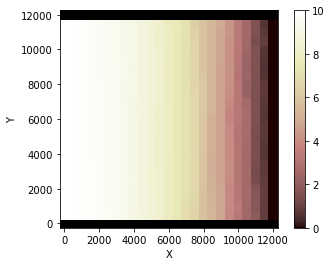

In [6]:
figure()
imshow_grid_at_node(mg, h)


In [14]:
figure()
plot_links(mg, 'conduit__discharge', use_PIL=True, )

figure()
plot_links(mg, 'diss__rates', use_PIL=True)

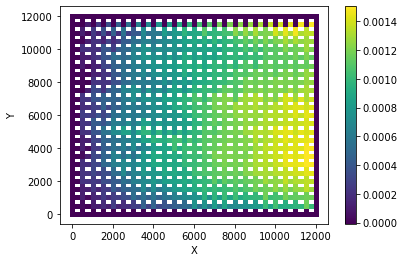

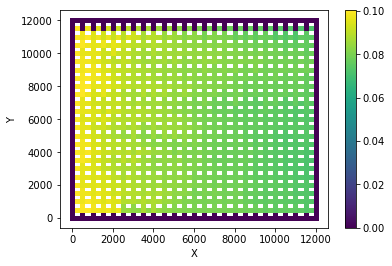

In [8]:
plot_links(mg, 'Ca__conc_in', use_PIL=False)
figure()
plot_links(mg, 'PCO2__conc_in', use_PIL=False)


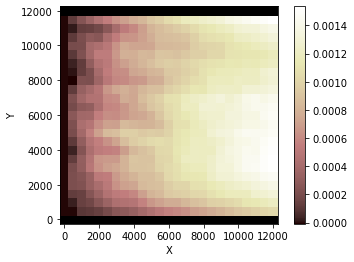

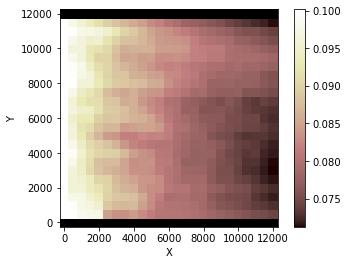

In [9]:
imshow_grid_at_node(mg, Ca)
figure()
imshow_grid_at_node(mg, PCO2)


In [5]:
#mg.at_node['concentration__Ca']
mg.at_link['diss__rates']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

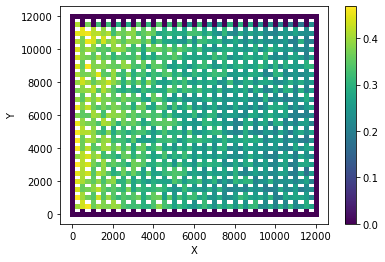

In [10]:
plot_links(mg, 'hydraulic__diameter', use_PIL=False)

In [7]:
this_node_links = mg.links_at_node[575]
this_node_dirs = mg.active_link_dirs_at_node[575]
print (this_node_dirs)
print(this_node_links)
node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
node_inflow_links = this_node_links[node_Qs>0]
node_outflow_links = this_node_links[node_Qs<0]
print(len(node_inflow_links))
print(node_outflow_links)

total_inflow = np.abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                            mg.at_node['input__discharge'][575]
print(total_inflow)


sum(np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['Ca__conc_out'][node_inflow_links])

[-1  0  0  0]
[1127 1151   -1 1102]
0
[1127]
0.0


0.0

In [6]:
mg.length_of_link

array([ 500.,  500.,  500., ...,  500.,  500.,  500.])

In [15]:
def test(a=1,b=2,c=3, d=None, e=0):
    return a*b*c*d*e

t1={'a':5,'b':42,'c':3}
t2 = {'d':4,'e':5}
test(**t2, **t1)

#test != None

12600

In [6]:
from olm.calcite import palmerRate, concCaEqFromPCO2

In [8]:
concCaEqFromPCO2(0.05,T_C=15.)

0.0033976549243382144

In [10]:
palmerRate(25., [0.005,0.01], [0.5,0.75])
concCaEqFromPCO2(array([0.01,0.02]), T_C=array([15.,25.]))

array([ 0.00190117,  0.00205579])

In [11]:
#Get index of nodes sorted by descending head
idx = np.argsort(-h)#Sort on negative to get descending order sort
#Loop through nodes from highest to lowest hydraulic head
for node_idx in idx:
    #Determine link indicies and directions for this node
    this_node_links = mg.links_at_node[node_idx]
    this_node_dirs = mg.active_link_dirs_at_node[node_idx]

    #Determine which links have inflow and outflow to/from node
    node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
    node_inflow_links = this_node_links[node_Qs>0]
    node_outflow_links = this_node_links[node_Qs<0]

    #Calculate node concentration from inflows (including boundary inflows)
    total_inflow = abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                    mg.at_node['input__discharge'][node_idx]

    #avoid cases with no inflow (e.g. closed boundaries)
    if total_inflow !=0:
        #Will need a loop here to loop through solutes
        conc_mult = np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['conduit__conc_out'][node_inflow_links]
        input_conc_mult = mg.at_node['input__discharge'][node_idx]*mg.at_node['input__concentration'][node_idx]
        conc_node = (conc_mult.sum() + input_conc_mult)/total_inflow
        C[node_idx] = conc_node
        
        #set outflow link concentrations
        mg.at_link['conduit__conc_in'][node_outflow_links] = conc_node
        
        #Calculate output link concentrations (for now conservative)
        mg.at_link['conduit__conc_out'][node_outflow_links] = mg.at_link['conduit__conc_in'][node_outflow_links]




FieldError: conduit__conc_out